## CSE 253: Assignment 2

### Tarun Kumar Gupta, A69033596
### Jai Malegaonkar, A69032721

## Task 2: Conditioned Symbolic Music Generation

In [1]:
!pip install pretty_midi numpy pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 64.1 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.6 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592286 sha256=5f219abdb29b7ef36c5e38b77859ea926a53807564608b283fb4276ccabcaecc
  Stored in directory: /root/.cache/pip/wheels/e6/95/ac/15ceaeb2823b04d8e638fd1495357adb8d26c00ccac9d7782e
Successfully built pretty_midi


In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/maestro-mid/maestro-midi - Copy/maestro-v3.0.0.csv
/kaggle/input/maestro-mid/maestro-midi - Copy/validation/MIDI-Unprocessed_01_R1_2009_01-04_ORIG_MID--AUDIO_01_R1_2009_01_R1_2009_04_WAV.midi
/kaggle/input/maestro-mid/maestro-midi - Copy/validation/ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_01_R1_2013_wav--2.midi
/kaggle/input/maestro-mid/maestro-midi - Copy/validation/MIDI-Unprocessed_R2_D2-19-21-22_mid--AUDIO-from_mp3_19_R2_2015_wav--3.midi
/kaggle/input/maestro-mid/maestro-midi - Copy/validation/MIDI-Unprocessed_042_PIANO042_MID--AUDIO-split_07-06-17_Piano-e_1-02_wav--2.midi
/kaggle/input/maestro-mid/maestro-midi - Copy/validation/ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_01_R1_2013_wav--3.midi
/kaggle/input/maestro-mid/maestro-midi - Copy/validation/MIDI-Unprocessed_SMF_13_01_2004_01-05_ORIG_MID--AUDIO_13_R1_2004_10_Track10_wav.midi
/kaggle/input/maestro-mid/maestro-midi - Copy/validation/ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_01_R1_2013_wav--4.midi
/kaggle/input/maestro-mid/ma

## Preprocessing data and tokenization

In [3]:
import numpy as np
import pretty_midi
from pathlib import Path

# ————————————————————————————————————————————————————————————————————————————————
# A) Load & quantize so that active_notes[t] contains ALL pitches sounding at step t
# ————————————————————————————————————————————————————————————————————————————————

def load_and_quantize_midi(midi_path, steps_per_quarter=16):
    """
    1) Loads a MIDI (midi_path may be a string or Path; we convert to str for PrettyMIDI).
    2) Estimates one global tempo (MAESTRO is mostly constant‐tempo).
    3) Quantizes the audio into 'steps_per_quarter' subdivisions per quarter note.
    4) Builds active_notes[t] = list of all MIDI pitches sounding at the center of bin t.
    Returns:
      pm           = a PrettyMIDI object
      times        = array([0, Δt, 2Δt, …, n_steps*Δt])
      active_notes = length‐n_steps list of lists: active_notes[t] are the pitches sounding at t
      tempo_bpm    = the estimated BPM (float)
    """
    pm = pretty_midi.PrettyMIDI(str(midi_path))
    tempo_bpm      = pm.estimate_tempo()  
    sec_per_quarter = 60.0 / tempo_bpm
    subdivision_s   = sec_per_quarter / steps_per_quarter

    total_duration = pm.get_end_time()
    n_steps = int(np.ceil(total_duration / subdivision_s))
    times   = np.arange(0.0, (n_steps + 1) * subdivision_s, subdivision_s)

    # Build the active_notes list
    active_notes = [[] for _ in range(n_steps)]
    for inst in pm.instruments:
        for note in inst.notes:
            t_start = int(np.floor(note.start / subdivision_s))
            t_end   = int(np.floor(note.end   / subdivision_s))
            # For every bin index t where start ≤ t_center < end, mark note.pitch active
            for t in range(max(0, t_start), min(n_steps, t_end + 1)):
                t_center = (t + 0.5) * subdivision_s
                if note.start <= t_center < note.end:
                    active_notes[t].append(note.pitch)

    return pm, times, active_notes, tempo_bpm


# Precompute all major/minor triads in pitch-class space:
MAJORS = []
MINORS = []
for r in range(12):
    MAJORS.append((r, sorted([r, (r + 4) % 12, (r + 7) % 12])))
    MINORS.append((r, sorted([r, (r + 3) % 12, (r + 7) % 12])))


def pitches_to_chord(pitches):
    """
    Given a list of MIDI pitches (e.g. [60, 64, 67, 72]), 
    return the best‐matching major/minor triad as "C:maj" or "D#:min".
    If pitches == [], return "N.C." (no chord).
    """
    if not pitches:
        return "N.C."

    pcs = sorted({p % 12 for p in pitches})
    best_score = -1
    best = None

    for (r, triad) in MAJORS:
        score = len(set(triad) & set(pcs))
        if score > best_score:
            best_score = score
            best = (r, "maj")
    for (r, triad) in MINORS:
        score = len(set(triad) & set(pcs))
        if score > best_score:
            best_score = score
            best = (r, "min")

    if best is None:
        return "N.C."

    root_pc, quality = best
    midi_root = root_pc + 60                  # map 0→C4=60, 1→C#4=61, etc.
    root_name = pretty_midi.note_number_to_name(midi_root)[:-1]  # e.g. "C#" (drop octave)
    return f"{root_name}:{quality}"


def extract_chord_and_melody(active_notes, subdivision_s):
    """
    Given active_notes[t] (list of pitches sounding at step t),
    produce two parallel lists of tokens (length = n_steps):
      chords[t] = "<CHORD=...>"
      melody[t] = "<MELODY=...>" 
    - chord = best‐matching triad of all active pitches
    - melody = highest active pitch’s note‐name, or "REST" if none active
    """
    n_steps = len(active_notes)
    chords = []
    melody = []
    for t in range(n_steps):
        pitches = active_notes[t]
        # (1) Chord label:
        chord_label = pitches_to_chord(pitches)
        chords.append(f"<CHORD={chord_label}>")
        # (2) Melody label:
        if not pitches:
            melody.append("<MELODY=REST>")
        else:
            highest = max(pitches)
            note_name = pretty_midi.note_number_to_name(highest)
            melody.append(f"<MELODY={note_name}>")
    return chords, melody


def build_interleaved_token_sequence(chords, melody):
    """
    Interleave two equal‐length lists into a single space‐separated string:
      <CHORD=...> <MELODY=...> <CHORD=...> <MELODY=...> … <EOS>
    """
    tokens = []
    for c, m in zip(chords, melody):
        tokens.append(c)
        tokens.append(m)
    tokens.append("<EOS>")
    return " ".join(tokens)


# ————————————————————————————————————————————————————————————————————————————————
# B) Loop over train/validation/test to rewrite every .txt using the active-notes method
# ————————————————————————————————————————————————————————————————————————————————

maestro_root = Path("/kaggle/input/maestro-mid/maestro-midi - Copy")
out_root     = Path("/kaggle/working/maestro-tokenize")
out_root.mkdir(exist_ok=True)

for split in ["train", "validation", "test"]:
    midi_folder = maestro_root / split
    out_folder  = out_root / split
    out_folder.mkdir(parents=True, exist_ok=True)

    for midi_file in sorted(midi_folder.glob("*.midi")):
        # 1) Quantize and gather ACTIVE notes:
        pm, times, active_notes, tempo_bpm = load_and_quantize_midi(
            str(midi_file), steps_per_quarter=16
        )

        # 2) Compute chords & melody lists
        #    (Ignore times and subdivision_s here if you don’t need NEXT_CYCLE markers.)
        chords, melody = extract_chord_and_melody(active_notes, subdivision_s=(60.0/tempo_bpm)/16)

        # 3) Interleave into one long token string
        token_seq = build_interleaved_token_sequence(chords, melody)

        # 4) Write to .txt
        out_path = out_folder / (midi_file.stem + ".txt")
        with open(out_path, "w", encoding="utf-8") as f:
            f.write(token_seq + "\n")

        print(f"Tokenized (fixed): {midi_file.name} → {out_path.name}")

print("✅ Done writing tokenized‐fixed files to:", out_root)


Tokenized (fixed): MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_02_R1_2014_wav--5.midi → MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_02_R1_2014_wav--5.txt
Tokenized (fixed): MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_03_R1_2014_wav--2.midi → MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_03_R1_2014_wav--2.txt
Tokenized (fixed): MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_03_R1_2014_wav--3.midi → MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_03_R1_2014_wav--3.txt
Tokenized (fixed): MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_03_R1_2014_wav--4.midi → MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_03_R1_2014_wav--4.txt
Tokenized (fixed): MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_03_R1_2014_wav--5.midi → MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_03_R1_2014_wav--5.txt
Tokenized (fixed): MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_03_R1_2014_wav--6.midi → MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_03_R1_2014_wav--6.txt
Tokenized (fixed): MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_04_R1_2014_wav--1.midi → MIDI-UNPROCESS

## Data Visualization and Stats

In [4]:
import os
import glob
import collections
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display   # ← add this

# ─────────────────────────────────────────────────────────────────────────────
# 1) Set this to the folder where your training .txt files actually live
# ─────────────────────────────────────────────────────────────────────────────
TRAIN_FOLDER = "/kaggle/working/maestro-tokenize/train"  # ◀ Update this!

# ─────────────────────────────────────────────────────────────────────────────
# 2) Initialize counters and stats collection
# ─────────────────────────────────────────────────────────────────────────────
total_tokens = 0
melody_counter = collections.Counter()
chord_counter = collections.Counter()
file_stats = []

# ─────────────────────────────────────────────────────────────────────────────
# 3) Loop through each .txt in TRAIN_FOLDER and gather token-level stats
# ─────────────────────────────────────────────────────────────────────────────
for filepath in glob.glob(f"{TRAIN_FOLDER}/*.txt"):
    filename = os.path.basename(filepath)
    with open(filepath, "r", encoding="utf-8") as f:
        tokens = f.read().strip().split()
    
    # Count how many melody vs chord tokens in this file
    num_tokens = len(tokens)
    melody_tokens = [tok for tok in tokens if tok.startswith("<MELODY=")]
    chord_tokens  = [tok for tok in tokens if tok.startswith("<CHORD=")]
    num_melody    = len(melody_tokens)
    num_non_rest  = sum(1 for tok in melody_tokens if tok != "<MELODY=REST>")
    num_chords    = len(chord_tokens)
    
    # Append per-file stats
    file_stats.append({
        "file": filename,
        "total_tokens": num_tokens,
        "melody_tokens": num_melody,
        "non_rest_melody": num_non_rest,
        "chord_tokens": num_chords
    })
    
    # Update global counters
    total_tokens += num_tokens
    melody_counter.update(melody_tokens)
    chord_counter.update(chord_tokens)
    

# ─────────────────────────────────────────────────────────────────────────────
# 4) If no files were found, warn and stop
# ─────────────────────────────────────────────────────────────────────────────
if not file_stats:
    print(f"No .txt files found in {TRAIN_FOLDER}. Please double-check that path!")
else:
    # ─────────────────────────────────────────────────────────────────────────
    # 5) Build a DataFrame of per-file stats, add percentages, and show top 10
    # ─────────────────────────────────────────────────────────────────────────
    file_stats_df = pd.DataFrame(file_stats)
    file_stats_df["pct_melody"] = file_stats_df["melody_tokens"] / file_stats_df["total_tokens"] * 100
    file_stats_df["pct_non_rest_melody"] = (
        file_stats_df["non_rest_melody"] / file_stats_df["melody_tokens"].replace(0, 1)
    ) * 100
    file_stats_df = file_stats_df.sort_values(by="total_tokens", ascending=False)
    
    # Use display() to render the DataFrame as a table in Kaggle
    display(file_stats_df.head(10))


,file,total_tokens,melody_tokens,non_rest_melody,chord_tokens,pct_melody,pct_non_rest_melody
240,MIDI-UNPROCESSED_04-07-08-10-12-15-17_R2_2014_...,293451,146725,106898,146725,49.999830,72.856023
913,MIDI-UNPROCESSED_19-20-21_R2_2014_MID--AUDIO_1...,284555,142277,109088,142277,49.999824,76.672969
1174,MIDI-Unprocessed_Recital1-3_MID--AUDIO_02_R1_2...,283117,141558,112509,141558,49.999823,79.479083
418,MIDI-UNPROCESSED_06-08_R1_2014_MID--AUDIO_08_R...,280493,140246,90272,140246,49.999822,64.366898
525,MIDI-Unprocessed_Schubert10-12_MID--AUDIO_20_R...,278751,139375,96296,139375,49.999821,69.091300
141,MIDI-Unprocessed_Schubert4-6_MID--AUDIO_10_R2_...,274383,137191,110576,137191,49.999818,80.600039
646,MIDI-UNPROCESSED_04-07-08-10-12-15-17_R2_2014_...,272703,136351,103896,136351,49.999817,76.197461
815,MIDI-Unprocessed_Schubert4-6_MID--AUDIO_09_R2_...,272487,136243,99443,136243,49.999817,72.989438
176,MIDI-Unprocessed_XP_06_R1_2004_01_ORIG_MID--AU...,253825,126912,110112,126912,49.999803,86.762481
915,MIDI-Unprocessed_Schubert7-9_MID--AUDIO_15_R2_...,241481,120740,92057,120740,49.999793,76.243995


In [5]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Paths to tokenized data
train_folder = "/kaggle/working/maestro-tokenize/train"
val_folder = "/kaggle/working/maestro-tokenize/validation"
test_folder = "/kaggle/working/maestro-tokenize/test"


# Function to read tokens from a directory and count statistics
def analyze_tokenized_folder(folder_path):
    all_tokens = []
    token_counts = Counter()
    melody_counts = Counter()
    chord_counts = Counter()
    file_lengths = []

    for filepath in glob.glob(os.path.join(folder_path, "*.txt")):
        with open(filepath, "r", encoding="utf-8") as f:
            tokens = f.read().strip().split()
            file_lengths.append(len(tokens))
            all_tokens.extend(tokens)
            token_counts.update(tokens)
            for tok in tokens:
                if tok.startswith("<MELODY="):
                    melody_counts[tok] += 1
                elif tok.startswith("<CHORD="):
                    chord_counts[tok] += 1
    
    return {
        "token_counts": token_counts,
        "melody_counts": melody_counts,
        "chord_counts": chord_counts,
        "file_lengths": file_lengths
    }

# Analyze train, validation, and test sets
train_stats = analyze_tokenized_folder(train_folder)
val_stats = analyze_tokenized_folder(val_folder)
test_stats = analyze_tokenized_folder(test_folder)

# Convert top counts to DataFrames
def top_n_to_df(counter, n=20, label="Token"):
    most_common = counter.most_common(n)
    df = pd.DataFrame(most_common, columns=[label, "Count"])
    df["Percentage"] = df["Count"] / sum(counter.values()) * 100
    return df

top_melody_df = top_n_to_df(train_stats["melody_counts"], n=20, label="Melody Token")
top_chord_df = top_n_to_df(train_stats["chord_counts"], n=20, label="Chord Token")

# Display DataFrames
display("Top 20 Melody Token Frequencies (Train)", top_melody_df)

'Top 20 Melody Token Frequencies (Train)'

,Melody Token,Count,Percentage
0,<MELODY=REST>,7810927,21.470837
1,<MELODY=C5>,1257938,3.457846
2,<MELODY=D5>,1182136,3.249480
3,<MELODY=A4>,1092347,3.002666
4,<MELODY=B4>,1050487,2.887600
5,<MELODY=C#5>,1048790,2.882936
6,<MELODY=D#5>,1047063,2.878188
7,<MELODY=A#4>,1043975,2.869700
8,<MELODY=G4>,1013304,2.785391
9,<MELODY=E5>,991425,2.725249


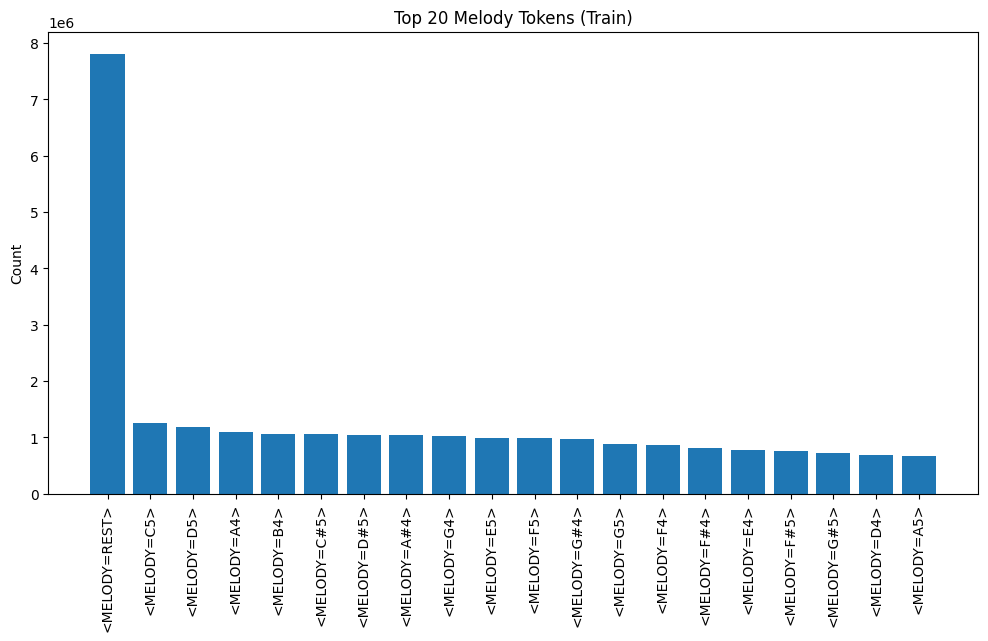

In [6]:
# Plot top 20 melody tokens
plt.figure(figsize=(12, 6))
plt.bar(top_melody_df["Melody Token"], top_melody_df["Count"])
plt.xticks(rotation=90)
plt.title("Top 20 Melody Tokens (Train)")
plt.ylabel("Count")
plt.show()

In [7]:
display("Top 20 Chord Token Frequencies (Train)", top_chord_df)

'Top 20 Chord Token Frequencies (Train)'

,Chord Token,Count,Percentage
0,<CHORD=N.C.>,7810927,21.470837
1,<CHORD=C:maj>,5570133,15.311296
2,<CHORD=C#:maj>,4681865,12.869607
3,<CHORD=D:maj>,4274374,11.749487
4,<CHORD=D#:maj>,2983511,8.201136
5,<CHORD=E:maj>,1905348,5.237460
6,<CHORD=F:maj>,1245873,3.424681
7,<CHORD=G:maj>,1213985,3.337027
8,<CHORD=G#:maj>,1110938,3.053769
9,<CHORD=A#:maj>,1052145,2.892158


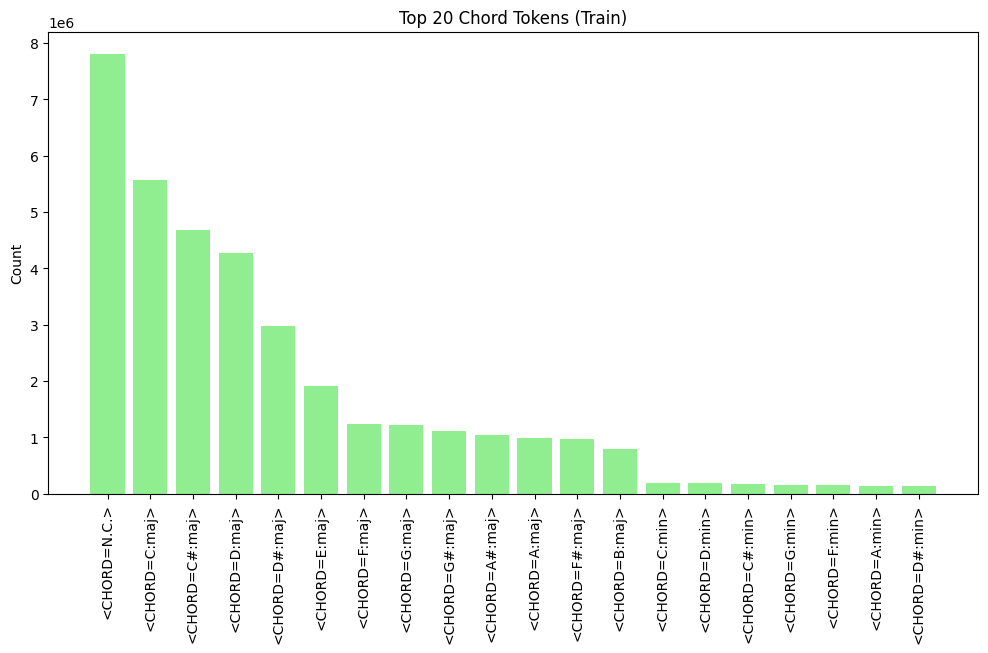

In [8]:
# Plot top 20 chord tokens
plt.figure(figsize=(12, 6))
plt.bar(top_chord_df["Chord Token"], top_chord_df["Count"], color='lightgreen')
plt.xticks(rotation=90)
plt.title("Top 20 Chord Tokens (Train)")
plt.ylabel("Count")
plt.show()

In [9]:
# Compute rest vs non-rest in melody
total_melodies = sum(train_stats["melody_counts"].values())
rest_count = train_stats["melody_counts"].get("<MELODY=REST>", 0)
non_rest_count = total_melodies - rest_count
rest_ratio = rest_count / total_melodies * 100
non_rest_ratio = non_rest_count / total_melodies * 100

rest_vs_nonrest_df = pd.DataFrame({
    "Category": ["REST", "Non-REST"],
    "Count": [rest_count, non_rest_count],
    "Percentage": [rest_ratio, non_rest_ratio]
})
display("Rest vs Non-Rest Distribution (Train)", rest_vs_nonrest_df)

'Rest vs Non-Rest Distribution (Train)'

,Category,Count,Percentage
0,REST,7810927,21.470837
1,Non-REST,28568312,78.529163


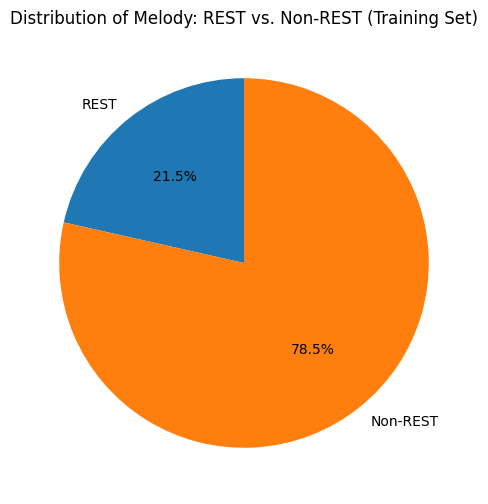

In [10]:
    # ─────────────────────────────────────────────────────────────────────────
    # 8) Pie chart: REST vs. non-REST among melody tokens
    # ─────────────────────────────────────────────────────────────────────────
    rest_count     = melody_counter["<MELODY=REST>"]
    non_rest_count = sum(count for tok, count in melody_counter.items() if tok != "<MELODY=REST>")

    plt.figure(figsize=(6, 6))
    plt.pie(
        [rest_count, non_rest_count],
        labels=["REST", "Non-REST"],
        autopct="%1.1f%%",
        startangle=90
    )
    plt.title("Distribution of Melody: REST vs. Non-REST (Training Set)")
    plt.show()

In [11]:
    # ─────────────────────────────────────────────────────────────────────────
    # 9) Overall summary statistics (single‐row table)
    # ─────────────────────────────────────────────────────────────────────────
    summary_stats = {
        "Total Tokens":             [total_tokens],
        "Total Melody Tokens":      [sum(melody_counter.values())],
        "Total Non-REST Melody":    [non_rest_count],
        "Pct. Melody Tokens of All": [sum(melody_counter.values()) / total_tokens * 100],
        "Pct. Non-REST of Melody":  [non_rest_count / sum(melody_counter.values()) * 100]
    }
    summary_df = pd.DataFrame(summary_stats)
    display("Overall Dataset Summary Statistics", summary_df)


'Overall Dataset Summary Statistics'

,Total Tokens,Total Melody Tokens,Total Non-REST Melody,Pct. Melody Tokens of All,Pct. Non-REST of Melody
0,72759657,36379239,28568312,49.99919,78.529163


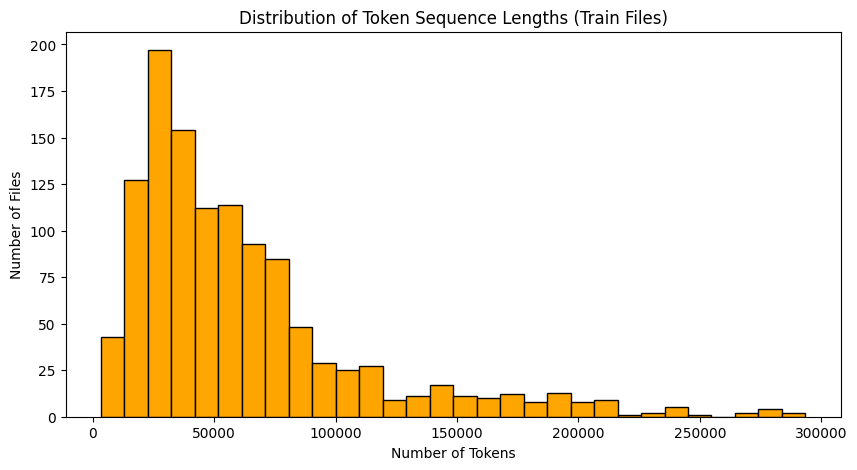

In [12]:
# Sequence length distribution (train set)
lengths = train_stats["file_lengths"]
plt.figure(figsize=(10, 5))
plt.hist(lengths, bins=30, color='orange', edgecolor='black')
plt.title("Distribution of Token Sequence Lengths (Train Files)")
plt.xlabel("Number of Tokens")
plt.ylabel("Number of Files")
plt.show()

In [13]:
# Summary statistics
lengths_summary = pd.Series(lengths).describe().to_frame(name="Value")
display("Summary of Sequence Lengths (Train)", lengths_summary)

'Summary of Sequence Lengths (Train)'

,Value
count,1179.000000
mean,61713.025445
std,48828.442747
min,3375.000000
25%,28838.000000
50%,47301.000000
75%,74867.000000
max,293451.000000


In [14]:
# Compare file length mean/median across splits
split_lengths = {
    "Train": train_stats["file_lengths"],
    "Validation": val_stats["file_lengths"],
    "Test": test_stats["file_lengths"]
}

summary_split = {}
for split, lens in split_lengths.items():
    arr = np.array(lens)
    summary_split[split] = {
        "Count": len(arr),
        "Mean Length": np.mean(arr),
        "Median Length": np.median(arr),
        "Std Dev": np.std(arr),
    }
summary_split_df = pd.DataFrame(summary_split).T
display("Sequence Length Summary by Split", summary_split_df)


'Sequence Length Summary by Split'

,Count,Mean Length,Median Length,Std Dev
Train,1179.0,61713.025445,47301.0,48807.730788
Validation,78.0,52280.461538,38125.0,38364.642025
Test,19.0,53444.157895,40895.0,36992.337888


## Baseline model

In [15]:
import os
import glob
from collections import Counter, defaultdict
import random
import numpy as np

# ─────────────────────────────────────────────────────────────────────────────
# 1) Build the chord→melody frequency table from TRAINING DATA
# ─────────────────────────────────────────────────────────────────────────────

# Change this path to wherever your train-folder of tokenized .txt lives
TRAIN_FOLDER = "/kaggle/working/maestro-tokenize/train"

# We will build two mappings:
#   counts[(chord_label)][melody_token] = count of how often melody_token follows chord_label
#   mode_map[chord_label] = most frequent melody_token after that chord
#   dist_map[chord_label] = list of (melody_token, probability) for sampling
counts = defaultdict(Counter)

# Iterate through every .txt in TRAIN_FOLDER
for filepath in glob.glob(os.path.join(TRAIN_FOLDER, "*.txt")):
    with open(filepath, "r", encoding="utf-8") as f:
        tokens = f.read().strip().split()
    # tokens is a flat list: <CHORD=...>, <MELODY=...>, <CHORD=...>, <MELODY=...>, ...
    # We assume they always come in pairs, so every even index is a chord, odd index is a melody.
    # However, sometimes we insert <EOS> at the end; skip it if found.
    for i in range(0, len(tokens) - 1, 2):
        chord_tok = tokens[i]
        if not chord_tok.startswith("<CHORD="):
            continue
        melody_tok = tokens[i + 1]
        if not melody_tok.startswith("<MELODY="):
            continue
        # Extract just the label inside <CHORD=> (e.g. "C:maj"), similarly for melody
        chord_label = chord_tok[len("<CHORD=") : -1]    # drop the trailing '>'
        melody_label = melody_tok[len("<MELODY=") : -1] # e.g. "C4" or "REST"
        counts[chord_label][melody_label] += 1

# Now build two convenience maps:
#   1) mode_map[chord_label] = melody_label with highest count
#   2) dist_map[chord_label] = list of (melody_label, prob) for sampling
mode_map = {}
dist_map = {}

for chord_label, melody_counter in counts.items():
    # Mode
    most_common_melody, _ = melody_counter.most_common(1)[0]
    mode_map[chord_label] = most_common_melody

    # Distribution for sampling
    total = sum(melody_counter.values())
    dist = []
    for mel_label, c in melody_counter.items():
        dist.append((mel_label, c / total))
    dist_map[chord_label] = dist

# For any chord not seen in training, we default to REST
DEFAULT_MELODY = "REST"

# ─────────────────────────────────────────────────────────────────────────────
# 2) Baseline generation functions
# ─────────────────────────────────────────────────────────────────────────────

def baseline_mode_generate(chord_prog, num_steps_per_chord=1):
    """
    Deterministic baseline: always pick mode_map[chord] (most frequent observed).
      chord_prog: list of chord strings, e.g. ["C:maj", "G:maj", "E:min", "F:maj"]
      num_steps_per_chord: how many times to repeat each chord→melody pair (usually 1)
    Returns a list of melody_labels (e.g. ["C4", "C4", "G3", "G3", ...]) of length len(chord_prog)*num_steps_per_chord
    """
    output = []
    for chord_label in chord_prog:
        mel = mode_map.get(chord_label, DEFAULT_MELODY)
        for _ in range(num_steps_per_chord):
            output.append(mel)
    return output

def baseline_random_generate(chord_prog, num_steps_per_chord=1, seed=None):
    """
    Stochastic baseline: sample melody from P(melody|chord) = dist_map[chord].
    Falling back to REST if chord not seen.
      seed: for reproducibility
    """
    if seed is not None:
        random.seed(seed)
    output = []
    for chord_label in chord_prog:
        dist = dist_map.get(chord_label, [(DEFAULT_MELODY, 1.0)])  # fallback to REST
        # Build sampling array
        tokens, probs = zip(*dist)
        for _ in range(num_steps_per_chord):
            mel = random.choices(tokens, weights=probs, k=1)[0]
            output.append(mel)
    return output

# ─────────────────────────────────────────────────────────────────────────────
# 3) Example usage:
# ─────────────────────────────────────────────────────────────────────────────

# Suppose we have a 4‐bar chord loop, each chord lasting 1 quantized step:
example_chord_prog = ["C:maj", "G:maj", "E:min", "F:maj"]

# Deterministic baseline (most frequent melody per chord):
print("MODE baseline for example progression:")
print(baseline_mode_generate(example_chord_prog, num_steps_per_chord=1))

# Random baseline sampling:
print("\nRANDOM baseline for example progression (seed=0):")
print(baseline_random_generate(example_chord_prog, num_steps_per_chord=1, seed=0))

# ─────────────────────────────────────────────────────────────────────────────
# 4) (Optional) Evaluate baseline accuracy on VALIDATION SET
# ─────────────────────────────────────────────────────────────────────────────

VAL_FOLDER = "/kaggle/working/maestro-tokenize/validation"

total_tokens = 0
correct_mode  = 0
correct_random = 0

# We'll generate with random baseline once per file; for a fair comparison use mode only.
# Here we illustrate mode baseline accuracy only.

for filepath in glob.glob(os.path.join(VAL_FOLDER, "*.txt")):
    with open(filepath, "r", encoding="utf-8") as f:
        tokens = f.read().strip().split()

    # Process in pairs: (chord_label, true_melody_label)
    for i in range(0, len(tokens) - 1, 2):
        chord_tok = tokens[i]
        melody_tok = tokens[i + 1]
        if (not chord_tok.startswith("<CHORD=")) or (not melody_tok.startswith("<MELODY=")):
            continue
        chord_label = chord_tok[len("<CHORD=") : -1]
        true_melody = melody_tok[len("<MELODY=") : -1]
        pred_mel = mode_map.get(chord_label, DEFAULT_MELODY)
        if pred_mel == true_melody:
            correct_mode += 1
        total_tokens += 1

mode_accuracy = correct_mode / total_tokens if total_tokens > 0 else 0.0
print(f"\nMODE Baseline Accuracy on validation: {mode_accuracy:.4f} "
      f"({correct_mode}/{total_tokens})")


MODE baseline for example progression:
['C5', 'B4', 'B4', 'C5']

RANDOM baseline for example progression (seed=0):
['A5', 'G5', 'B4', 'F5']

MODE Baseline Accuracy on validation: 0.3262 (664994/2038899)


## Markov Chains

In [16]:
import os
import glob
import random
from collections import defaultdict, Counter

# ─────────────────────────────────────────────────────────────────────────────
# 1) Build the Markov chain from TRAINING DATA (first-order bigrams)
# ─────────────────────────────────────────────────────────────────────────────

TRAIN_FOLDER = "/kaggle/working/maestro-tokenize/train"

# transitions[token] = Counter of tokens that follow 'token'
transitions = defaultdict(Counter)
start_counts = Counter()

for filepath in glob.glob(os.path.join(TRAIN_FOLDER, "*.txt")):
    with open(filepath, "r", encoding="utf-8") as f:
        tokens = f.read().strip().split()
    if not tokens:
        continue
    
    # Record the first token as a potential start state
    start_counts[tokens[0]] += 1
    
    # Count all bigram transitions
    for curr_tok, next_tok in zip(tokens[:-1], tokens[1:]):
        transitions[curr_tok][next_tok] += 1

# Normalize transitions into probabilities
transition_prob = {}
for curr_tok, counter in transitions.items():
    total = sum(counter.values())
    next_tokens, counts = zip(*counter.items())
    probs = [c / total for c in counts]
    transition_prob[curr_tok] = (list(next_tokens), list(probs))

# Normalize start-state distribution
if start_counts:
    start_tokens, start_counts_list = zip(*start_counts.items())
    start_total = sum(start_counts_list)
    start_probs = [c / start_total for c in start_counts_list]
else:
    start_tokens, start_probs = [], []


# ─────────────────────────────────────────────────────────────────────────────
# 2) Generation function using the Markov chain
# ─────────────────────────────────────────────────────────────────────────────

def markov_generate(max_steps=512, seed=None):
    """
    Generate up to max_steps tokens by sampling:
      - First token sampled from start_tokens with start_probs.
      - Each subsequent token sampled from P(next | current) = transition_prob[current].
      - If current token has no transitions, sample a new start token.
      - Stop early if "<EOS>" is generated.
    """
    if seed is not None:
        random.seed(seed)
    
    if not start_tokens:
        return []
    
    # Sample initial token
    current = random.choices(start_tokens, weights=start_probs, k=1)[0]
    generated = [current]
    
    for _ in range(max_steps - 1):
        if current in transition_prob:
            next_tokens, next_probs = transition_prob[current]
            next_tok = random.choices(next_tokens, weights=next_probs, k=1)[0]
        else:
            # Fallback to a random start token if no outgoing transitions
            next_tok = random.choices(start_tokens, weights=start_probs, k=1)[0]
        
        generated.append(next_tok)
        if next_tok == "<EOS>":
            break
        current = next_tok
    
    return generated


# ─────────────────────────────────────────────────────────────────────────────
# 3) Example usage: generate a sample sequence
# ─────────────────────────────────────────────────────────────────────────────
sampled_sequence = markov_generate(max_steps=512, seed=0)
print("Generated token sequence (first 50 tokens):")
print(sampled_sequence[:50])


# ─────────────────────────────────────────────────────────────────────────────
# 4) Evaluate next‐token prediction accuracy on VALIDATION SET
# ─────────────────────────────────────────────────────────────────────────────

VAL_FOLDER = "/kaggle/working/maestro-tokenize/validation"
total_pred = 0
correct_pred = 0

for filepath in glob.glob(os.path.join(VAL_FOLDER, "*.txt")):
    with open(filepath, "r", encoding="utf-8") as f:
        tokens = f.read().strip().split()
    for curr_tok, true_next in zip(tokens[:-1], tokens[1:]):
        if curr_tok in transition_prob:
            next_tokens, next_probs = transition_prob[curr_tok]
            # Predict the highest‐probability next token (mode)
            pred_next = next_tokens[next_probs.index(max(next_probs))]
        else:
            # If we have no data for curr_tok, skip it
            continue
        
        if pred_next == true_next:
            correct_pred += 1
        total_pred += 1

accuracy = correct_pred / total_pred if total_pred > 0 else 0.0
print(f"\nMarkov chain next‐token accuracy on validation: {accuracy:.4f} "
      f"({correct_pred}/{total_pred})")


Generated token sequence (first 50 tokens):
['<CHORD=N.C.>', '<MELODY=REST>', '<CHORD=N.C.>', '<MELODY=REST>', '<CHORD=N.C.>', '<MELODY=REST>', '<CHORD=N.C.>', '<MELODY=REST>', '<CHORD=N.C.>', '<MELODY=REST>', '<CHORD=C:maj>', '<MELODY=C5>', '<CHORD=C:maj>', '<MELODY=G5>', '<CHORD=G:maj>', '<MELODY=G4>', '<CHORD=C#:maj>', '<MELODY=A#5>', '<CHORD=C:maj>', '<MELODY=E6>', '<CHORD=C:maj>', '<MELODY=G5>', '<CHORD=N.C.>', '<MELODY=REST>', '<CHORD=N.C.>', '<MELODY=REST>', '<CHORD=N.C.>', '<MELODY=REST>', '<CHORD=C:maj>', '<MELODY=A#5>', '<CHORD=F#:maj>', '<MELODY=F#6>', '<CHORD=D:maj>', '<MELODY=A5>', '<CHORD=D:maj>', '<MELODY=A2>', '<CHORD=F:maj>', '<MELODY=A4>', '<CHORD=C:maj>', '<MELODY=C6>', '<CHORD=F:maj>', '<MELODY=C4>', '<CHORD=N.C.>', '<MELODY=REST>', '<CHORD=N.C.>', '<MELODY=REST>', '<CHORD=N.C.>', '<MELODY=REST>', '<CHORD=N.C.>', '<MELODY=REST>']

Markov chain next‐token accuracy on validation: 0.4494 (1832751/4077798)


## Transformer

In [17]:
import os
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

# ----------------------------
# 1. Configuration
# ----------------------------

SEED = 42
torch.manual_seed(SEED)

DATA_ROOT = Path("/kaggle/working/maestro-tokenize")
TRAIN_DIR = DATA_ROOT / "train"
VAL_DIR   = DATA_ROOT / "validation"
TEST_DIR  = DATA_ROOT / "test"

BATCH_SIZE = 8
SEQ_LEN = 512     # choose based on GPU memory & sequence lengths
EMBED_DIM = 256
NUM_HEADS = 8
NUM_LAYERS = 6
DROPOUT = 0.1
LR = 2e-4
NUM_EPOCHS = 25

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ----------------------------
# 2. Build Vocabulary
# ----------------------------

token_set = set()
for file in TRAIN_DIR.glob("*.txt"):
    with open(file, "r", encoding="utf-8") as f:
        tokens = f.read().strip().split()
        token_set.update(tokens)

# Optionally add "<PAD>" if you want to do fixed-length padding
# token_set.add("<PAD>")

tokens = sorted(token_set)
token_to_id = {tok: idx for idx, tok in enumerate(tokens)}
id_to_token = {idx: tok for tok, idx in token_to_id.items()}
vocab_size = len(tokens)
print(f"[Info] Vocab size = {vocab_size} tokens")

torch.save(token_to_id, "maestro_token_to_id.pth")
torch.save(id_to_token, "maestro_id_to_token.pth")


# ----------------------------
# 3. Dataset & DataLoader
# ----------------------------

class MaestroLM(Dataset):
    """
    Each .txt in train/validation/test is a single line:
      <CHORD=...> <MELODY=...> <CHORD=...> <MELODY=...> ... <EOS>
    We convert tokens→IDs, then randomly sample windows of length=SEQ_LEN+1
    for next-token prediction.
    """
    def __init__(self, folder, token_to_id, seq_len):
        self.seqs = []
        self.seq_len = seq_len
        self.token_to_id = token_to_id

        for file in Path(folder).glob("*.txt"):
            with open(file, "r", encoding="utf-8") as f:
                tokens = f.read().strip().split()
                if len(tokens) < seq_len + 1:
                    continue
                ids = [self.token_to_id[t] for t in tokens]
                self.seqs.append(ids)

    def __len__(self):
        return len(self.seqs)

    def __getitem__(self, idx):
        ids = self.seqs[idx]
        start = torch.randint(0, len(ids) - self.seq_len - 1, (1,)).item()
        window = ids[start : start + self.seq_len + 1]
        inp = torch.tensor(window[:-1], dtype=torch.long)
        tgt = torch.tensor(window[1:],  dtype=torch.long)
        return inp, tgt

train_ds = MaestroLM(TRAIN_DIR, token_to_id, SEQ_LEN)
val_ds   = MaestroLM(VAL_DIR,   token_to_id, SEQ_LEN)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  drop_last=True)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=True)


# ----------------------------
# 4. Transformer Language Model
# ----------------------------

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(
            torch.arange(0, d_model, 2, dtype=torch.float32) * -(math.log(10000.0)/d_model)
        )
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe)

    def forward(self, x):
        """
        x: (seq_len, batch, d_model)
        """
        x = x + self.pe[: x.size(0), :].unsqueeze(1)  # broadcast over batch
        return x

class TransformerLM(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, dropout):
        super().__init__()
        self.token_embed = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim, max_len=SEQ_LEN)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=4*embed_dim,
            dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.ln = nn.LayerNorm(embed_dim)
        self.output_head = nn.Linear(embed_dim, vocab_size)

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz) * float("-inf"), diagonal=1)
        return mask

    def forward(self, src):
        """
        src: (batch, seq_len)
        returns: logits (batch, seq_len, vocab_size)
        """
        batch, seq_len = src.size()
        src = src.transpose(0, 1)  # (seq_len, batch)
        embed = self.token_embed(src) * math.sqrt(EMBED_DIM)
        embed = self.pos_encoder(embed)
        mask = self.generate_square_subsequent_mask(seq_len).to(embed.device)
        out = self.transformer_encoder(embed, mask)  # (seq_len, batch, embed_dim)
        out = self.ln(out)
        logits = self.output_head(out)  # (seq_len, batch, vocab_size)
        return logits.transpose(0, 1)   # (batch, seq_len, vocab_size)

model = TransformerLM(vocab_size, EMBED_DIM, NUM_HEADS, NUM_LAYERS, DROPOUT).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()


# ----------------------------
# 5. Training & Validation
# ----------------------------

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    for i, (inp, tgt) in enumerate(train_dl):
        inp = inp.to(DEVICE)
        tgt = tgt.to(DEVICE)
        optimizer.zero_grad()
        logits = model(inp)  # (batch, seq_len, vocab)
        loss = criterion(logits.reshape(-1, vocab_size), tgt.reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()
        if (i+1) % 200 == 0:
            avg = train_loss / 200
            print(f"[Epoch {epoch+1}] Step {i+1}/{len(train_dl)}  Train Loss = {avg:.4f}")
            train_loss = 0.0

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inp, tgt in val_dl:
            inp = inp.to(DEVICE)
            tgt = tgt.to(DEVICE)
            logits = model(inp)
            loss = criterion(logits.reshape(-1, vocab_size), tgt.reshape(-1))
            val_loss += loss.item()
    val_loss /= len(val_dl)
    print(f"*** Epoch {epoch+1} Validation Loss = {val_loss:.4f} ***")

# Save final model
torch.save(model.state_dict(), "maestro_chord2melody_lm.pth")
print("Training complete. Model saved to maestro_chord2melody_lm.pth")


[Info] Vocab size = 115 tokens


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


*** Epoch 1 Validation Loss = 1.6317 ***
*** Epoch 2 Validation Loss = 1.3065 ***
*** Epoch 3 Validation Loss = 1.1556 ***
*** Epoch 4 Validation Loss = 1.0312 ***
*** Epoch 5 Validation Loss = 0.8651 ***
*** Epoch 6 Validation Loss = 0.8370 ***
*** Epoch 7 Validation Loss = 0.7888 ***
*** Epoch 8 Validation Loss = 0.7601 ***
*** Epoch 9 Validation Loss = 0.6929 ***
*** Epoch 10 Validation Loss = 0.6440 ***
*** Epoch 11 Validation Loss = 0.6345 ***
*** Epoch 12 Validation Loss = 0.6275 ***
*** Epoch 13 Validation Loss = 0.5677 ***
*** Epoch 14 Validation Loss = 0.6184 ***
*** Epoch 15 Validation Loss = 0.6225 ***
*** Epoch 16 Validation Loss = 0.6523 ***
*** Epoch 17 Validation Loss = 0.5826 ***
*** Epoch 18 Validation Loss = 0.6022 ***
*** Epoch 19 Validation Loss = 0.5932 ***
*** Epoch 20 Validation Loss = 0.6062 ***
*** Epoch 21 Validation Loss = 0.6252 ***
*** Epoch 22 Validation Loss = 0.5799 ***
*** Epoch 23 Validation Loss = 0.5829 ***
*** Epoch 24 Validation Loss = 0.5813 ***
*

## Transformer Eval and MIDI Generation (Chord Input -> Melody)

In [18]:
import torch
from pretty_midi import PrettyMIDI, Instrument, Note

# ─────────────────────────────────────────────────────────────────────────────
# (A) Build your chord‐only prefix (unchanged except for indentation)
# ─────────────────────────────────────────────────────────────────────────────

chord_prog = ["A:maj", "B:maj", "C#:min", "E:maj", "D#:maj", "F:maj"]  # your 4‐bar loop

prefix_tokens = []
for chord in chord_prog:
    for _ in range(16):        # 16 steps per quarter‐note
        prefix_tokens.append(f"<CHORD={chord}>")
        prefix_tokens.append("<MELODY=REST>")  # placeholder

# Convert prefix → IDs, pad/trim to SEQ_LEN
prefix_ids = [token_to_id[t] for t in prefix_tokens]
if len(prefix_ids) < SEQ_LEN:
    pad_id = token_to_id.get("<PAD>", token_to_id["<EOS>"])
    prefix_ids = [pad_id] * (SEQ_LEN - len(prefix_ids)) + prefix_ids
else:
    prefix_ids = prefix_ids[-SEQ_LEN:]

input_ids = torch.tensor(prefix_ids, dtype=torch.long).unsqueeze(0).to(DEVICE)

# ─────────────────────────────────────────────────────────────────────────────
# (B) Compute how many tokens correspond to 1–2 minutes of music
# ─────────────────────────────────────────────────────────────────────────────

tempo_bpm         = 120.0       # must match training‐time tempo (or whatever you choose)
steps_per_quarter = 16          # must match the “resolution=16” you trained on
sec_per_quarter   = 60.0 / tempo_bpm
subdivision_s     = sec_per_quarter / steps_per_quarter

# Choose desired maximum duration (in seconds). For example, 90 s (1.5 min)
max_duration_secs = 90.0

# Each “step” in generation (one <CHORD> or <MELODY> token) advances time by subdivision_s
# We interleave chord+melody, but we still count tokens one‐by‐one. So:
max_steps = int(max_duration_secs / subdivision_s)

print(f"→ Each token step = {subdivision_s:.4f} s; "
      f"{max_steps} steps ≃ {max_steps * subdivision_s:.1f} s")

# ─────────────────────────────────────────────────────────────────────────────
# (C) Autoregressive sampling loop (stop after max_steps)
# ─────────────────────────────────────────────────────────────────────────────

model.eval()
generated = prefix_tokens.copy()

for step in range(max_steps):
    with torch.no_grad():
        logits = model(input_ids)       # (1, SEQ_LEN, vocab_size)
    next_logits = logits[0, -1]         # (vocab_size,)
    probs = torch.softmax(next_logits / 1.0, dim=-1)   # temperature=1.0
    next_id = torch.multinomial(probs, num_samples=1).item()
    next_tok    = id_to_token[next_id]
    generated.append(next_tok)

    # Slide window by 1 token
    input_ids = input_ids.squeeze(0).tolist()
    input_ids = input_ids[1:] + [next_id]
    input_ids = torch.tensor([input_ids], dtype=torch.long).to(DEVICE)

    if next_tok == "<EOS>":
        break
else:
    print(f"→ Reached {max_steps} tokens; stopping at ≈{max_duration_secs} s")

# (D) Print the first few generated tokens to check for real melodies
print("\nFirst 50 generated tokens:")
print(generated[:50])

# ─────────────────────────────────────────────────────────────────────────────
# (D) Write the generated tokens to MIDI (unchanged)
# ─────────────────────────────────────────────────────────────────────────────

def tokens_to_midi(generated_tokens, subdivision_s, out_midi_path):
    pm          = PrettyMIDI()
    inst        = Instrument(program=0)
    current_time = 0.0
    open_notes   = {}  # midi_pitch → note_start_time

    for tok in generated_tokens:
        if tok.startswith("<CHORD="):
            # We do not advance time for chord tokens themselves; they share the same step as the following <MELODY>
            continue

        elif tok.startswith("<MELODY="):
            note_name = tok.replace("<MELODY=", "").rstrip(">")
            if note_name == "REST":
                # Close any currently open notes
                for pitch, start_time in list(open_notes.items()):
                    note = Note(velocity=100, pitch=pitch,
                                start=start_time, end=current_time)
                    inst.notes.append(note)
                    del open_notes[pitch]
            else:
                midi_num = pretty_midi.note_name_to_number(note_name)
                # If that pitch is already open, end it now
                if midi_num in open_notes:
                    note = Note(velocity=100, pitch=midi_num,
                                start=open_notes[midi_num], end=current_time)
                    inst.notes.append(note)
                # Start a new note
                open_notes[midi_num] = current_time

            # Advance time by one subdiv step
            current_time += subdivision_s

        elif tok == "<NEXT_CYCLE>":
            current_time += subdivision_s

        elif tok == "<EOS>":
            break

    # Close any lingering open notes at the end
    for pitch, start_time in open_notes.items():
        note = Note(velocity=100, pitch=pitch,
                    start=start_time, end=current_time)
        inst.notes.append(note)

    pm.instruments.append(inst)
    pm.write(out_midi_path)
    print(f"→ Written MIDI to: {out_midi_path}")

# Finally, call it:
tokens_to_midi(generated, subdivision_s, "generated_output.mid")


→ Each token step = 0.0312 s; 2880 steps ≃ 90.0 s
→ Reached 2880 tokens; stopping at ≈90.0 s

First 50 generated tokens:
['<CHORD=A:maj>', '<MELODY=REST>', '<CHORD=A:maj>', '<MELODY=REST>', '<CHORD=A:maj>', '<MELODY=REST>', '<CHORD=A:maj>', '<MELODY=REST>', '<CHORD=A:maj>', '<MELODY=REST>', '<CHORD=A:maj>', '<MELODY=REST>', '<CHORD=A:maj>', '<MELODY=REST>', '<CHORD=A:maj>', '<MELODY=REST>', '<CHORD=A:maj>', '<MELODY=REST>', '<CHORD=A:maj>', '<MELODY=REST>', '<CHORD=A:maj>', '<MELODY=REST>', '<CHORD=A:maj>', '<MELODY=REST>', '<CHORD=A:maj>', '<MELODY=REST>', '<CHORD=A:maj>', '<MELODY=REST>', '<CHORD=A:maj>', '<MELODY=REST>', '<CHORD=A:maj>', '<MELODY=REST>', '<CHORD=B:maj>', '<MELODY=REST>', '<CHORD=B:maj>', '<MELODY=REST>', '<CHORD=B:maj>', '<MELODY=REST>', '<CHORD=B:maj>', '<MELODY=REST>', '<CHORD=B:maj>', '<MELODY=REST>', '<CHORD=B:maj>', '<MELODY=REST>', '<CHORD=B:maj>', '<MELODY=REST>', '<CHORD=B:maj>', '<MELODY=REST>', '<CHORD=B:maj>', '<MELODY=REST>']
→ Written MIDI to: generated

## Model Comparison

In [19]:
import os
import glob
import math
import torch
import torch.nn as nn
from collections import Counter, defaultdict

# ─────────────────────────────────────────────────────────────────────────────
# (A) Load your Transformer and token mappings
# ─────────────────────────────────────────────────────────────────────────────
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEQ_LEN = 512

# load token_to_id / id_to_token (must match training)
token_to_id = torch.load("maestro_token_to_id.pth")
id_to_token = torch.load("maestro_id_to_token.pth")
vocab_size = len(token_to_id)

# Define your TransformerLM exactly as in training code
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(
            torch.arange(0, d_model, 2, dtype=torch.float32) * -(math.log(10000.0)/d_model)
        )
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe)

    def forward(self, x):
        """
        x: (seq_len, batch, d_model)
        """
        x = x + self.pe[: x.size(0), :].unsqueeze(1)
        return x

class TransformerLM(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, dropout):
        super().__init__()
        self.token_embed = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim, max_len=SEQ_LEN)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=4 * embed_dim,
            dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers
        )
        self.ln = nn.LayerNorm(embed_dim)
        self.output_head = nn.Linear(embed_dim, vocab_size)

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz) * float("-inf"), diagonal=1)
        return mask

    def forward(self, src):
        """
        src: (batch, seq_len) → returns (batch, seq_len, vocab_size)
        """
        batch, seq_len = src.size()
        x = src.transpose(0, 1)                       # (seq_len, batch)
        embed = self.token_embed(x) * math.sqrt(256)  # scale by sqrt(embed_dim)
        embed = self.pos_encoder(embed)
        mask = self.generate_square_subsequent_mask(seq_len).to(embed.device)
        out = self.transformer_encoder(embed, mask)   # (seq_len, batch, embed_dim)
        out = self.ln(out)
        logits = self.output_head(out)                # (seq_len, batch, vocab_size)
        return logits.transpose(0, 1)                 # → (batch, seq_len, vocab_size)

# Instantiate and load weights
model = TransformerLM(vocab_size, embed_dim=256, num_heads=8, num_layers=6, dropout=0.1).to(DEVICE)
model.load_state_dict(torch.load("maestro_chord2melody_lm.pth", map_location=DEVICE))
model.eval()

# ─────────────────────────────────────────────────────────────────────────────
# (B) Load baselines: Markov chain & Chord→Melody mode
# ─────────────────────────────────────────────────────────────────────────────

# 1) Markov‐chain: load transition_prob & start_tokens from previous cell or re‐build here
#    For brevity, assume they’re in `transition_prob` and `start_tokens, start_probs` from earlier.
#    If not, re‐run the Markov‐chain building code, exactly as in the previous snippet.

from collections import defaultdict, Counter
import random

TRAIN_FOLDER = "/kaggle/working/maestro-tokenize/train"

# Build transitions again:
transitions = defaultdict(Counter)
start_counts = Counter()
for filepath in glob.glob(os.path.join(TRAIN_FOLDER, "*.txt")):
    with open(filepath, "r", encoding="utf-8") as f:
        tokens = f.read().strip().split()
    if not tokens:
        continue
    start_counts[tokens[0]] += 1
    for a, b in zip(tokens[:-1], tokens[1:]):
        transitions[a][b] += 1

transition_prob = {}
for curr_tok, counter in transitions.items():
    total = sum(counter.values())
    next_tokens, counts = zip(*counter.items())
    probs = [c / total for c in counts]
    transition_prob[curr_tok] = (list(next_tokens), list(probs))

if start_counts:
    start_tokens, start_counts_list = zip(*start_counts.items())
    total_start = sum(start_counts_list)
    start_probs = [c / total_start for c in start_counts_list]
else:
    start_tokens, start_probs = [], []

# 2) Chord→Melody mode baseline: rebuild mode_map if needed (as in previous snippet)
counts = defaultdict(Counter)
for filepath in glob.glob(os.path.join(TRAIN_FOLDER, "*.txt")):
    with open(filepath, "r", encoding="utf-8") as f:
        tokens = f.read().strip().split()
    for i in range(0, len(tokens)-1, 2):
        c = tokens[i]
        m = tokens[i+1]
        if c.startswith("<CHORD=") and m.startswith("<MELODY="):
            chord_label = c[len("<CHORD="):-1]
            melody_label = m[len("<MELODY="):-1]
            counts[chord_label][melody_label] += 1

mode_map = {}
for chord_label, melody_counter in counts.items():
    mode_map[chord_label] = melody_counter.most_common(1)[0][0]

DEFAULT_MELODY = "REST"

# ─────────────────────────────────────────────────────────────────────────────
# (C) Next‐token accuracy on VALIDATION SET
# ─────────────────────────────────────────────────────────────────────────────

VAL_FOLDER = "/kaggle/working/maestro-tokenize/validation"

# Accumulators for each model
totals = {"markov": 0, "chord_mode": 0, "transformer": 0}
correct = {"markov": 0, "chord_mode": 0, "transformer": 0}

# For Transformer, we will need a sliding window of length SEQ_LEN.
# If a sequence is shorter than SEQ_LEN+1, skip it (just like during training).
for filepath in glob.glob(os.path.join(VAL_FOLDER, "*.txt")):
    with open(filepath, "r", encoding="utf-8") as f:
        tokens = f.read().strip().split()

    # Skip short files
    if len(tokens) < SEQ_LEN + 1:
        continue

    # Precompute all predicted tokens for Transformer in one forward pass:
    # We'll slide a window of size SEQ_LEN over tokens[0: len(tokens)-1] to predict tokens[1:].
    # Collect predicted IDs in an array of length len(tokens)-1
    transformer_preds = [None] * (len(tokens) - 1)

    # Slide windows in chunks of size SEQ_LEN
    for start in range(0, len(tokens) - SEQ_LEN - 1 + 1, SEQ_LEN):
        window_tokens = tokens[start : start + SEQ_LEN]   # these are token strings
        input_ids = torch.tensor(
            [token_to_id[t] for t in window_tokens], dtype=torch.long
        ).unsqueeze(0).to(DEVICE)  # shape (1, SEQ_LEN)

        with torch.no_grad():
            logits = model(input_ids)  # (1, SEQ_LEN, vocab_size)
            preds = torch.argmax(logits, dim=-1).squeeze(0).tolist()  
            # preds[i] = predicted ID for position i in the window → next token for window_tokens[i]
        
        # Map preds back to token strings and store
        for i, pid in enumerate(preds):
            transformer_preds[start + i] = id_to_token[pid]

    # If the final few tokens (< SEQ_LEN) remain unfilled in transformer_preds, you can process them with a final window
    remainder = (len(tokens) - 1) % SEQ_LEN
    if remainder != 0:
        start = len(tokens) - 1 - SEQ_LEN
        if start < 0:
            start = 0
        window_tokens = tokens[start : start + SEQ_LEN]
        input_ids = torch.tensor(
            [token_to_id[t] for t in window_tokens], dtype=torch.long
        ).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            logits = model(input_ids)
            preds = torch.argmax(logits, dim=-1).squeeze(0).tolist()
        for i, pid in enumerate(preds):
            idx = start + i
            if idx < len(tokens) - 1: 
                transformer_preds[idx] = id_to_token[pid]

    # Now loop through each true bigram (curr_tok → true_next)
    for idx in range(len(tokens) - 1):
        curr_tok = tokens[idx]
        true_next = tokens[idx + 1]

        # 1) Markov‐chain prediction:
        if curr_tok in transition_prob:
            next_toks, next_probs = transition_prob[curr_tok]
            mode_next = next_toks[next_probs.index(max(next_probs))]
        else:
            # if unseen, choose a random start (we skip these in accuracy)
            mode_next = None

        if mode_next == true_next:
            correct["markov"] += 1
        if mode_next is not None:
            totals["markov"] += 1

        # 2) Chord→Melody mode baseline:
        if curr_tok.startswith("<CHORD="):
            chord_label = curr_tok[len("<CHORD="):-1]
            baseline_mel = mode_map.get(chord_label, DEFAULT_MELODY)
            # The “true next” in multi‐token sequence is also a melody if idx is even; 
            # if idx is odd, curr_tok was a <MELODY=> and true_next is a <CHORD=>, so skip.
            if true_next.startswith("<MELODY="):
                # Compare <MELODY=blabla> vs. baseline_mel (string like "C4" or "REST")
                true_mel = true_next[len("<MELODY="):-1]
                if baseline_mel == true_mel:
                    correct["chord_mode"] += 1
                totals["chord_mode"] += 1

        # 3) Transformer prediction:
        pred_tok = transformer_preds[idx]
        if pred_tok == true_next:
            correct["transformer"] += 1
        totals["transformer"] += 1


# Compute accuracies
acc_markov     = correct["markov"] / totals["markov"] if totals["markov"] else 0.0
acc_chord_mode = correct["chord_mode"] / totals["chord_mode"] if totals["chord_mode"] else 0.0
acc_transformer = correct["transformer"] / totals["transformer"] if totals["transformer"] else 0.0

print("Next‐token Accuracy on Validation:")
print(f"  Chord→Melody Mode base:  {acc_chord_mode:.4f}  ({correct['chord_mode']}/{totals['chord_mode']})")
print(f"  Markov‐chain baseline:   {acc_markov:.4f}  ({correct['markov']}/{totals['markov']})")
print(f"  Transformer LM:          {acc_transformer:.4f}  ({correct['transformer']}/{totals['transformer']})")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Next‐token Accuracy on Validation:
  Chord→Melody Mode base:  0.3262  (664994/2038899)
  Markov‐chain baseline:   0.4494  (1832751/4077798)
  Transformer LM:          0.8732  (3560613/4077798)


## Task 4: Continuous Conditioned Music Generation

These was .py files which we pasted into the notebook

In [ ]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

import json
import torch
import torchaudio
import numpy as np
import logging
import random
import gc
import subprocess
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Tuple, Optional, Union
from dataclasses import dataclass
from collections import defaultdict

from torch.utils.data import Dataset, DataLoader, random_split
from torch.amp import GradScaler, autocast
from torch.nn.utils import clip_grad_norm_
from tqdm.auto import tqdm

from transformers import (
    AutoProcessor, 
    MusicgenForConditionalGeneration,
    get_linear_schedule_with_warmup
)

import soundfile as sf
import librosa
import pandas as pd

In [ ]:
logger = logging.getLogger(__name__)

def debug_audio_shapes(model, processor, audio_batch, text_batch):
    """Debug audio encoding shapes"""
    print("\n=== Debug Audio Shapes ===")
    print(f"Input audio shape: {audio_batch.shape}")
    print(f"Text batch length: {len(text_batch)}")
    
    with torch.no_grad():
        # Test encoding
        if hasattr(model, 'audio_encoder'):
            encoded = model.audio_encoder(audio_batch)
            if hasattr(encoded, 'audio_codes'):
                audio_codes = encoded.audio_codes
            else:
                audio_codes = encoded[0] if isinstance(encoded, tuple) else encoded
            
            print(f"Encoded audio codes shape: {audio_codes.shape}")
            print(f"Number of codebooks: {audio_codes.shape[1] if audio_codes.ndim > 2 else 1}")
            
            # Test model forward pass
            try:
                # Create dummy inputs
                dummy_text = processor(
                    text=text_batch,
                    padding=True,
                    return_tensors="pt"
                ).to(audio_batch.device)
                
                # Prepare labels
                if audio_codes.ndim == 2:
                    audio_codes = audio_codes.unsqueeze(1)
                elif audio_codes.ndim == 4:
                    audio_codes = audio_codes.squeeze(1)
                
                
                labels = audio_codes.permute(0, 2, 1)
                print(f"Labels shape for model: {labels.shape}")
                
                # Test forward pass
                outputs = model(
                    input_ids=dummy_text.input_ids,
                    attention_mask=dummy_text.attention_mask,
                    labels=labels
                )
                
                print(f"Loss computed successfully: {outputs.loss.item()}")
                
            except Exception as e:
                print(f"Error in forward pass: {e}")
                import traceback
                traceback.print_exc()

def fix_metadata_issues(metadata):
    """Fix common metadata issues that cause unhashable type errors"""
    if isinstance(metadata, dict):
        fixed = {}
        for key, value in metadata.items():
            if isinstance(value, dict):
                # Convert nested dicts to strings or extract relevant info
                if 'name' in value:
                    fixed[key] = value['name']
                elif 'common_name' in value:
                    fixed[key] = value['common_name']
                else:
                    fixed[key] = str(value)
            elif isinstance(value, list):
                # Handle lists of dicts
                if value and isinstance(value[0], dict):
                    fixed[key] = [fix_metadata_issues(item) for item in value]
                else:
                    fixed[key] = value
            else:
                fixed[key] = value
        return fixed
    return metadata

def create_simple_trainer(model_name="facebook/musicgen-small"):
    """Create a simplified trainer for testing"""
    from transformers import AutoProcessor, MusicgenForConditionalGeneration
    
    print("Creating simplified trainer...")
    
    # Load model and processor
    processor = AutoProcessor.from_pretrained(model_name)
    model = MusicgenForConditionalGeneration.from_pretrained(
        model_name,
        torch_dtype=torch.float32,
        low_cpu_mem_usage=True
    )
    
    # Configure for training
    model.config.use_cache = False
    model.gradient_checkpointing_enable()
    if hasattr(model, 'decoder'):
        model.decoder.config.decoder_start_token_id = \
            model.generation_config.decoder_start_token_id
    # Move to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    return model, processor

def test_with_dummy_data(model, processor):
    """Test training with dummy data"""
    print("\n=== Testing with dummy data ===")
    
    device = next(model.parameters()).device
    
    # Create dummy batch
    batch_size = 1
    audio_length = 32000 * 5  # 5 seconds
    
    # Dummy audio
    dummy_audio = torch.randn(batch_size, 1, audio_length).to(device)
    
    # Dummy text
    dummy_text = ["Indian classical music, Raag Yaman, sitar and tabla"]
    
    # Process inputs
    text_inputs = processor(
        text=dummy_text,
        padding=True,
        return_tensors="pt"
    ).to(device)
    
    # Encode audio
    with torch.no_grad():
        encoded = model.audio_encoder(dummy_audio)
        audio_codes = encoded.audio_codes if hasattr(encoded, 'audio_codes') else encoded[0]
    
    print(f"Audio codes shape: {audio_codes.shape}")
    print(len(audio_codes.shape), "dimensions detected in audio codes")
    # Prepare labels
    if len(audio_codes.shape) == 4:
        audio_codes = audio_codes.squeeze(1)
    elif len(audio_codes.shape) == 2:
        audio_codes = audio_codes.unsqueeze(1)

    print(f"Audio codes shape after prep: {audio_codes.shape}")
    labels = audio_codes.permute(0, 2, 1)
    print(f"Labels shape: {labels.shape}")
    
    # Forward pass
    try:
        outputs = model(
            input_ids=text_inputs.input_ids,
            attention_mask=text_inputs.attention_mask,
            labels=labels
        )
        
        print(f"✅ Forward pass successful! Loss: {outputs.loss.item()}")
        
        # Test backward pass
        outputs.loss.backward()
        print("✅ Backward pass successful!")
        
    except Exception as e:
        print(f"❌ Error: {e}")
        import traceback
        traceback.print_exc()

def create_minimal_training_loop():
    """Create a minimal training loop for debugging"""
    print("\n=== Minimal Training Loop ===")
    
    # Create model
    model, processor = create_simple_trainer()
    
    # Test with dummy data
    test_with_dummy_data(model, processor)
    
    # Create optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
    
    # Training loop
    model.train()
    for step in range(3):
        # Create random batch
        batch_size = 1
        audio_length = 32000 * 5
        
        dummy_audio = torch.randn(batch_size, 1, audio_length).to(model.device)
        dummy_text = [f"Test prompt {step}"]
        
        # Process
        text_inputs = processor(
            text=dummy_text,
            padding=True,
            return_tensors="pt"
        ).to(model.device)
        
        # Encode audio
        with torch.no_grad():
            encoded = model.audio_encoder(dummy_audio)
            audio_codes = encoded.audio_codes if hasattr(encoded, 'audio_codes') else encoded[0]
        
        # Prepare labels
        if audio_codes.ndim == 2:
            audio_codes = audio_codes.unsqueeze(1)
        elif audio_codes.ndim == 4:
            audio_codes = audio_codes.squeeze(1)
        
        labels = audio_codes.permute(0, 2, 1)
        print(f"Labels shape: {labels.shape}")
        # Forward pass
        outputs = model(
            input_ids=text_inputs.input_ids,
            attention_mask=text_inputs.attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        print(f"Step {step}: Loss = {loss.item():.4f}")
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print("✅ Minimal training loop completed successfully!")

if __name__ == "__main__":
    # Run diagnostic tests
    create_minimal_training_loop()

In [ ]:
# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('training.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# ==================== Configuration ====================
@dataclass
class TrainingConfig:
    """Training configuration"""
    # Model
    model_name: str = "facebook/musicgen-small"
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Data
    data_root: str = "data"
    chunk_duration: float = 10.0
    sample_rate: int = 32000
    use_audio_conditioning: bool = True
    conditioning_duration: float = 3.0
    
    # Training
    batch_size: int = 1
    accumulation_steps: int = 8
    num_epochs: int = 15
    learning_rate: float = 1e-5
    warmup_steps: int = 500
    weight_decay: float = 0.01
    max_grad_norm: float = 1.0
    
    # Validation
    val_split: float = 0.1
    eval_steps: int = 100
    
    # Checkpointing
    output_dir: str = "./musicgen-saraga-enhanced"
    checkpoint_steps: int = 500
    resume_from_checkpoint: Optional[str] = None
    
    # Generation
    generation_temperature: float = 0.9
    generation_top_p: float = 0.95
    guidance_scale: float = 3.0

# ==================== Data Processing ====================
class AudioProcessor:
    """Handle audio loading and preprocessing"""
    
    @staticmethod
    def convert_mp3_to_wav_ffmpeg(data_root: str, force_reconvert: bool = False) -> Tuple[int, int, int]:
        """Convert MP3 to WAV using ffmpeg"""
        data_path = Path(data_root)
        mp3_files = list(data_path.rglob("*.mp3"))
        
        logger.info(f"Found {len(mp3_files)} MP3 files")
        
        converted_count = skipped_count = error_count = 0
        
        for mp3_path in tqdm(mp3_files, desc="Converting MP3 to WAV"):
            wav_path = mp3_path.with_suffix('.wav')
            
            if wav_path.exists() and not force_reconvert:
                skipped_count += 1
                continue
            
            try:
                cmd = [
                    'ffmpeg', '-i', str(mp3_path),
                    '-acodec', 'pcm_s16le',
                    '-ar', '32000', '-ac', '1',
                    '-y', str(wav_path)
                ]
                
                result = subprocess.run(cmd, capture_output=True, text=True)
                
                if result.returncode == 0:
                    converted_count += 1
                else:
                    error_count += 1
                    logger.error(f"Error converting {mp3_path.name}: {result.stderr}")
                    
            except Exception as e:
                error_count += 1
                logger.error(f"Error with {mp3_path.name}: {e}")
        
        logger.info(f"Converted: {converted_count}, Skipped: {skipped_count}, Errors: {error_count}")
        return converted_count, skipped_count, error_count
    
    @staticmethod
    def load_audio(path: str, sr: int = 32000, duration: Optional[float] = None) -> torch.Tensor:
        """Load and preprocess audio"""
        try:
            waveform, orig_sr = torchaudio.load(path)
            
            # Resample if needed
            if orig_sr != sr:
                resampler = torchaudio.transforms.Resample(orig_sr, sr)
                waveform = resampler(waveform)
            
            # Convert to mono
            if waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)
            
            # Trim or pad to duration if specified
            if duration:
                target_samples = int(duration * sr)
                if waveform.shape[1] > target_samples:
                    waveform = waveform[:, :target_samples]
                else:
                    padding = target_samples - waveform.shape[1]
                    waveform = torch.nn.functional.pad(waveform, (0, padding))
            
            return waveform
        except Exception as e:
            logger.error(f"Error loading audio {path}: {e}")
            raise

class SaragaAnnotationParser:
    """Parse Saraga annotations for rich metadata"""
    
    @staticmethod
    def load_melodic_phrases(phrase_file: str) -> List[Dict]:
        """Load melodic phrase annotations"""
        phrases = []
        if not os.path.exists(phrase_file):
            return phrases
            
        try:
            with open(phrase_file, 'r', encoding='utf-8') as f:
                for line in f:
                    parts = line.strip().split('\t')
                    if len(parts) >= 3:
                        phrase = {
                            'start': float(parts[0]),
                            'duration': float(parts[2]),
                            'end': float(parts[0]) + float(parts[2]),
                            'notation': parts[3] if len(parts) > 3 else ''
                        }
                        phrases.append(phrase)
        except Exception as e:
            logger.warning(f"Error loading phrases from {phrase_file}: {e}")
        
        return phrases
    
    @staticmethod
    def load_sections(section_file: str) -> List[Dict]:
        """Load section annotations"""
        sections = []
        if not os.path.exists(section_file):
            return sections
            
        try:
            with open(section_file, 'r', encoding='utf-8') as f:
                for line in f:
                    parts = line.strip().split('\t')
                    if len(parts) >= 3:
                        sections.append({
                            'start': float(parts[0]),
                            'end': float(parts[1]),
                            'name': parts[2]
                        })
        except Exception as e:
            logger.warning(f"Error loading sections from {section_file}: {e}")
        
        return sections
    
    @staticmethod
    def load_tempo(tempo_file: str) -> Optional[float]:
        """Load tempo information"""
        try:
            if os.path.exists(tempo_file):
                with open(tempo_file, 'r') as f:
                    return float(f.read().strip())
        except:
            pass
        return None
    
    @staticmethod
    def load_tonic(tonic_file: str) -> Optional[float]:
        """Load tonic frequency"""
        try:
            if os.path.exists(tonic_file):
                with open(tonic_file, 'r') as f:
                    return float(f.read().strip())
        except:
            pass
        return None

# ==================== Dataset ====================
class EnhancedSaragaDataset(Dataset):
    """Enhanced dataset with rich metadata and audio conditioning support"""
    
    def __init__(
        self, 
        data_root: str,
        tradition: str = 'hindustani',
        chunk_duration: float = 10.0,
        sample_rate: int = 32000,
        use_audio_conditioning: bool = True,
        conditioning_duration: float = 3.0
    ):
        self.data_root = Path(data_root)
        self.tradition = tradition
        self.chunk_duration = chunk_duration
        self.sample_rate = sample_rate
        self.chunk_samples = int(chunk_duration * sample_rate)
        self.use_audio_conditioning = use_audio_conditioning
        self.conditioning_duration = conditioning_duration
        self.conditioning_samples = int(conditioning_duration * sample_rate)
        
        self.recordings = []
        self.annotation_parser = SaragaAnnotationParser()
        self._load_recordings()
        
    def _load_recordings(self):
        """Load all recordings with comprehensive metadata"""
        tradition_path = self.data_root / self.tradition
        
        for recording_dir in tradition_path.iterdir():
            if not recording_dir.is_dir():
                continue
            
            # Find metadata
            json_files = list(recording_dir.glob("*.json"))
            if not json_files:
                continue
            
            with open(json_files[0], 'r', encoding='utf-8') as f:
                metadata = json.load(f)
            
            # Find audio
            audio_files = list(recording_dir.glob("*.wav"))
            if not audio_files:
                continue
            
            audio_path = audio_files[0]
            base_name = audio_path.stem
            
            # Load all annotations
            recording = {
                'audio_path': str(audio_path),
                'metadata': metadata,
                'annotations': {
                    'phrases': self.annotation_parser.load_melodic_phrases(
                        str(recording_dir / f"{base_name}.mphrases-manual.txt")
                    ),
                    'sections': self.annotation_parser.load_sections(
                        str(recording_dir / f"{base_name}.sections-manual-p.txt")
                    ),
                    'tempo': self.annotation_parser.load_tempo(
                        str(recording_dir / f"{base_name}.tempo-manual.txt")
                    ),
                    'tonic': self.annotation_parser.load_tonic(
                        str(recording_dir / f"{base_name}.ctonic.txt")
                    )
                }
            }
            
            self.recordings.append(recording)
        
        logger.info(f"Loaded {len(self.recordings)} {self.tradition} recordings")
        self._log_statistics()
    
    def _log_statistics(self):
        """Log dataset statistics"""
        total_phrases = sum(len(r['annotations']['phrases']) for r in self.recordings)
        recordings_with_sections = sum(1 for r in self.recordings if r['annotations']['sections'])
        recording_with_tonics = sum(1 for r in self.recordings if r['annotations']['tonic'] is not None)
        recording_with_tempos = sum(1 for r in self.recordings if r['annotations']['tempo'] is not None)
        
        logger.info(f"Dataset statistics for {self.tradition}:")
        logger.info(f"  Total melodic phrases: {total_phrases}")
        logger.info(f"  Recordings with sections: {recordings_with_sections}")
        logger.info(f"  Recordings with tonic: {recording_with_tonics}")
        logger.info(f"  Recordings with tempo: {recording_with_tempos}")
    
    def _create_rich_description(self, recording: Dict) -> str:
        """Create detailed text description from all available metadata"""
        parts = [f"{self.tradition.capitalize()} classical music"]
        metadata = recording['metadata']
        annotations = recording['annotations']
        
        # Raag information
        if metadata.get('raags'):
            for raag in metadata['raags']:
                raag_name = raag.get('common_name', raag.get('name', ''))
                if raag_name:
                    parts.append(f"Raag {raag_name}")
                    # Add time of day if available
                    if 'time' in raag:
                        time_info = raag['time']
                        if isinstance(time_info, list) and time_info:
                            parts.append(f"performed in {time_info[0]}")
        
        # Taal information
        if metadata.get('taals'):
            for taal in metadata['taals']:
                taal_name = taal.get('common_name', taal.get('name', ''))
                if taal_name:
                    parts.append(f"Taal {taal_name}")
                    if 'beats' in taal:
                        parts.append(f"with {taal['beats']} beats")
        
        # Form/style
        if metadata.get('forms'):
            for form in metadata['forms']:
                form_name = form.get('name', '')
                if form_name:
                    parts.append(f"in {form_name} style")
        
        # Artists
        if metadata.get('artists'):
            instruments = []
            for artist in metadata['artists']:
                if 'instrument' in artist and isinstance(artist['instrument'], str):
                    instruments.append(artist['instrument'])
            if instruments:
                # Use list to maintain order, then convert to set for uniqueness
                unique_instruments = list(dict.fromkeys(instruments))
                parts.append(f"featuring {', '.join(unique_instruments)}")
        
        # Tempo
        if annotations['tempo'] is not None:
            try:
                tempo = float(annotations['tempo'])
                if tempo < 80:
                    parts.append("slow tempo")
                elif tempo < 120:
                    parts.append("medium tempo")
                else:
                    parts.append("fast tempo")
            except (ValueError, TypeError):
                pass
        
        # Current section context (will be dynamic during training)
        return ", ".join(parts)
    
    def _get_audio_chunk_with_context(self, waveform: torch.Tensor, recording: Dict) -> Tuple[torch.Tensor, Optional[torch.Tensor], str]:
        """Get audio chunk with optional conditioning and contextual description"""
        total_samples = waveform.shape[1]
        
        if total_samples <= self.chunk_samples:
            # Pad if too short
            padding = self.chunk_samples - total_samples
            main_chunk = torch.nn.functional.pad(waveform, (0, padding))
            conditioning = None
            context = ""
        else:
            # Select chunk with awareness of musical structure
            sections = recording['annotations']['sections']
            
            if sections and random.random() < 0.7:  # 70% chance to use section boundaries
                # Select a section
                section = random.choice(sections)
                section_start = int(section['start'] * self.sample_rate)
                section_end = int(section['end'] * self.sample_rate)
                
                if section_end - section_start >= self.chunk_samples:
                    # Sample within section
                    max_start = section_end - self.chunk_samples
                    start = random.randint(section_start, max_start)
                    context = f", {section['name']} section"
                else:
                    # Section too short, random sample
                    start = random.randint(0, total_samples - self.chunk_samples)
                    context = ""
            else:
                # Random sample
                start = random.randint(0, total_samples - self.chunk_samples)
                context = ""
            
            # Extract main chunk
            main_chunk = waveform[:, start:start + self.chunk_samples]
            
            # Extract conditioning chunk if enabled
            conditioning = None
            if self.use_audio_conditioning and start >= self.conditioning_samples:
                # Get audio from before the main chunk
                cond_start = start - self.conditioning_samples
                conditioning = waveform[:, cond_start:cond_start + self.conditioning_samples]
        
        return main_chunk, conditioning, context
    
    def __len__(self):
        return len(self.recordings)
    
    def __getitem__(self, idx):
        recording = self.recordings[idx]
        
        try:
            # Load full audio
            waveform = AudioProcessor.load_audio(recording['audio_path'], self.sample_rate)
            
            # Get chunk with optional conditioning
            main_chunk, conditioning, section_context = self._get_audio_chunk_with_context(waveform, recording)
            
            # Create description with context
            description = self._create_rich_description(recording) + section_context
            
            return {
                'audio': main_chunk,
                'conditioning': conditioning,
                'text': description,
                'metadata': recording['metadata']
            }
            
        except Exception as e:
            logger.error(f"Error loading recording {idx} ({recording.get('audio_path', 'unknown')}): {e}")
            # Return placeholder data with basic description
            return {
                'audio': torch.zeros(1, self.chunk_samples),
                'conditioning': None,
                'text': f"{self.tradition.capitalize()} classical music",
                'metadata': {}
            }

class CombinedSaragaDataset(Dataset):
    """Combined dataset for both traditions"""
    
    def __init__(self, config: TrainingConfig):
        self.config = config
        
        # Load both traditions
        self.hindustani_dataset = EnhancedSaragaDataset(
            data_root=config.data_root,
            tradition='hindustani',
            chunk_duration=config.chunk_duration,
            sample_rate=config.sample_rate,
            use_audio_conditioning=config.use_audio_conditioning,
            conditioning_duration=config.conditioning_duration
        )
        
        self.carnatic_dataset = EnhancedSaragaDataset(
            data_root=config.data_root,
            tradition='carnatic',
            chunk_duration=config.chunk_duration,
            sample_rate=config.sample_rate,
            use_audio_conditioning=config.use_audio_conditioning,
            conditioning_duration=config.conditioning_duration
        )
        
        self.total_length = len(self.hindustani_dataset) + len(self.carnatic_dataset)
        self.hindustani_length = len(self.hindustani_dataset)
        
        logger.info(f"Combined dataset size: {self.total_length}")
    
    def __len__(self):
        return self.total_length
    
    def __getitem__(self, idx):
        if idx < self.hindustani_length:
            return self.hindustani_dataset[idx]
        else:
            return self.carnatic_dataset[idx - self.hindustani_length]

# ==================== Training ====================
class EnhancedMusicGenTrainer:
    """Enhanced trainer with audio conditioning and better memory management"""
    
    def __init__(self, config: TrainingConfig):
        self.config = config
        self.device = torch.device(config.device)
        
        # Initialize processor and model
        logger.info(f"Loading model: {config.model_name}")
        self.processor = AutoProcessor.from_pretrained(config.model_name)
        
        self.model = MusicgenForConditionalGeneration.from_pretrained(
            config.model_name,
            torch_dtype=torch.float32,
            low_cpu_mem_usage=True,
            attn_implementation="eager"
            
        )
        
        # Configure model
        self._configure_model()
        
        # Move to device
        self.model = self.model.to(self.device)
        
        # Training state
        self.global_step = 0
        self.best_val_loss = float('inf')
        
        # Initialize trackers
        self.train_losses = []
        self.val_losses = []
        
    def _configure_model(self):
        """Configure model for training"""
        # Set up tokenizer
        self.processor.tokenizer.pad_token = self.processor.tokenizer.eos_token
        
        # Configure model
        self.model.config.use_cache = False
        self.model.generation_config.use_cache = False
        if hasattr(self.model, "decoder"):
            self.model.decoder.config.use_cache = False

            
        self.model.gradient_checkpointing_enable()
        
        # Set decoder start token
        if hasattr(self.model, 'decoder'):
            self.model.decoder.config.decoder_start_token_id = \
                self.model.generation_config.decoder_start_token_id
        
        # Freeze encoder
        if hasattr(self.model, 'audio_encoder'):
            for param in self.model.audio_encoder.parameters():
                param.requires_grad = False
    
    def prepare_inputs_for_training(self, batch: Dict) -> Optional[Dict]:
        """Prepare batch for training with audio conditioning support"""
        # Extract batch components
        audio_list = batch['audio']
        conditioning_list = batch.get('conditioning', [None] * len(audio_list))
        text_list = batch['text']
        
        # Filter out empty texts
        valid_indices = [i for i, text in enumerate(text_list) if text and text.strip()]
        if not valid_indices:
            return None
        
        audio_batch = torch.stack([audio_list[i] for i in valid_indices]).to(self.device)
        text_batch = [text_list[i] for i in valid_indices]
        conditioning_batch = [conditioning_list[i] for i in valid_indices]
        
        # Normalize audio
        audio_batch = audio_batch / (torch.max(torch.abs(audio_batch)) + 1e-7)
        
        # Encode audio to codes
        with torch.no_grad():
            if hasattr(self.model, 'audio_encoder'):
                encoded = self.model.audio_encoder(audio_batch)
                audio_codes = encoded.audio_codes if hasattr(encoded, 'audio_codes') else encoded[0]
            else:
                # Fallback if structure is different
                audio_codes = audio_batch
        
        # Ensure correct shape [B, C, T]
        if audio_codes.ndim == 2:
            audio_codes = audio_codes.unsqueeze(1)
        elif audio_codes.ndim == 4:
            # If shape is [B, K, 1, T], squeeze the unnecessary dimension
            audio_codes = audio_codes.squeeze(1)
        
        # Log shape for debugging
        logger.debug(f"Audio codes shape: {audio_codes.shape}")
        
        # For MusicGen, we need to handle multiple codebooks
        # The model expects labels in shape [B, C, T] where C is number of codebooks
        B, C, T = audio_codes.shape
        
        # Prepare labels with proper shift
        labels = audio_codes.clone()
        
        # Shift the sequences by 1 position for next-token prediction
        if T > 1:
            # For each codebook, shift by 1
            labels[:, :, :-1] = audio_codes[:, :, 1:]
            # Set the last position to a special token (usually pad or eos)
            labels[:, :, -1] = self.model.generation_config.pad_token_id
        
        # The first token should be the decoder start token
        labels[:, :, 0] = self.model.generation_config.decoder_start_token_id
        
        # Reshape labels to match MusicGen's expected format
        labels = labels.permute(0, 2, 1)
        
        # Process text
        text_inputs = self.processor(
            text=text_batch,
            padding=True,
            return_tensors="pt"
        ).to(self.device)
        
        # Prepare conditioning if available
        if self.config.use_audio_conditioning and any(c is not None for c in conditioning_batch):
            # Process conditioning audio
            valid_conditioning = []
            for c in conditioning_batch:
                if c is not None:
                    c = c.to(self.device)
                    c = c / (torch.max(torch.abs(c)) + 1e-7)
                    valid_conditioning.append(c)
                else:
                    # Use silence as placeholder
                    valid_conditioning.append(torch.zeros_like(audio_batch[0]))
            
            conditioning_tensor = torch.stack(valid_conditioning)
            
            # TODO: Implement audio conditioning in model forward pass
            # This would require modifying the model architecture
            # For now, we'll just use text conditioning
        
        return {
            "input_ids": text_inputs.input_ids,
            "attention_mask": text_inputs.attention_mask,
            "labels": labels
        }
    
    def train_step(self, batch: Dict) -> Optional[torch.Tensor]:
        """Single training step"""
        inputs = self.prepare_inputs_for_training(batch)
        if inputs is None:
            return None
        
        outputs = self.model(**inputs)
        return outputs.loss
    
    def validate(self, val_dataloader: DataLoader) -> float:
        """Run validation"""
        self.model.eval()
        val_losses = []
        
        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc="Validation"):
                try:
                    with autocast(device_type='cuda'):
                        loss = self.train_step(batch)
                        if loss is not None:
                            val_losses.append(loss.item())
                except Exception as e:
                    logger.warning(f"Validation step error: {e}")
        
        avg_val_loss = np.mean(val_losses) if val_losses else float('inf')
        self.model.train()
        return avg_val_loss
    
    def save_checkpoint(self, checkpoint_dir: str, is_best: bool = False):
        """Save model checkpoint"""
        checkpoint_path = Path(checkpoint_dir)
        checkpoint_path.mkdir(parents=True, exist_ok=True)
        
        # Save model and processor
        self.model.save_pretrained(checkpoint_path / "model")
        self.processor.save_pretrained(checkpoint_path / "processor")
        
        # Save training state
        state = {
            'global_step': self.global_step,
            'best_val_loss': self.best_val_loss,
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'config': self.config.__dict__
        }
        torch.save(state, checkpoint_path / "training_state.pt")
        
        if is_best:
            # Copy to best model directory
            best_path = Path(self.config.output_dir) / "best_model"
            best_path.mkdir(parents=True, exist_ok=True)
            self.model.save_pretrained(best_path / "model")
            self.processor.save_pretrained(best_path / "processor")
        
        logger.info(f"Checkpoint saved to {checkpoint_path}")
    
    def train(
        self, 
        train_dataloader: DataLoader,
        val_dataloader: Optional[DataLoader] = None
    ):
        """Main training loop"""
        # Setup optimizer
        optimizer = torch.optim.AdamW(
            filter(lambda p: p.requires_grad, self.model.parameters()),
            lr=self.config.learning_rate,
            weight_decay=self.config.weight_decay
        )
        
        # Setup scheduler
        num_training_steps = len(train_dataloader) * self.config.num_epochs
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.config.warmup_steps,
            num_training_steps=num_training_steps
        )
        
        # Setup gradient scaler for mixed precision
        scaler = GradScaler()
        
        # Training loop
        logger.info("Starting training...")
        for epoch in range(self.config.num_epochs):
            self.model.train()
            epoch_losses = []
            
            progress_bar = tqdm(
                train_dataloader,
                desc=f"Epoch {epoch+1}/{self.config.num_epochs}"
            )
            
            optimizer.zero_grad()
            
            for batch_idx, batch in enumerate(progress_bar):
                try:
                    # Forward pass with mixed precision
                    with autocast(device_type='cuda'):
                        loss = self.train_step(batch)
                        if loss is None:
                            continue
                        
                        # Scale loss for accumulation
                        loss = loss / self.config.accumulation_steps
                    
                    # Backward pass
                    scaler.scale(loss).backward()
                    
                    # Update weights
                    if (batch_idx + 1) % self.config.accumulation_steps == 0:
                        scaler.unscale_(optimizer)
                        clip_grad_norm_(self.model.parameters(), self.config.max_grad_norm)
                        scaler.step(optimizer)
                        scaler.update()
                        scheduler.step()
                        optimizer.zero_grad()
                        
                        self.global_step += 1
                    
                    # Track loss
                    epoch_losses.append(loss.item() * self.config.accumulation_steps)
                    
                    # Update progress bar
                    avg_loss = np.mean(epoch_losses[-100:])  # Running average
                    progress_bar.set_postfix({
                        'loss': f'{avg_loss:.4f}',
                        'lr': f'{scheduler.get_last_lr()[0]:.2e}',
                        'mem': f'{torch.cuda.memory_allocated()/1e9:.1f}GB'
                    })
                    
                    # Validation
                    if val_dataloader and self.global_step % self.config.eval_steps == 0:
                        val_loss = self.validate(val_dataloader)
                        self.val_losses.append((self.global_step, val_loss))
                        logger.info(f"Step {self.global_step}: val_loss = {val_loss:.4f}")
                        
                        # Save best model
                        if val_loss < self.best_val_loss:
                            self.best_val_loss = val_loss
                            self.save_checkpoint(
                                f"{self.config.output_dir}/checkpoint-best",
                                is_best=True
                            )
                    
                    # Regular checkpointing
                    if self.global_step % self.config.checkpoint_steps == 0:
                        self.save_checkpoint(
                            f"{self.config.output_dir}/checkpoint-{self.global_step}"
                        )
                    
                    # Memory cleanup
                    if batch_idx % 50 == 0:
                        torch.cuda.empty_cache()
                        gc.collect()
                        
                except RuntimeError as e:
                    if 'out of memory' in str(e):
                        logger.warning("OOM detected, skipping batch")
                        torch.cuda.empty_cache()
                        gc.collect()
                        optimizer.zero_grad()
                    else:
                        raise e
            
            # Epoch summary
            avg_epoch_loss = np.mean(epoch_losses)
            self.train_losses.append((epoch, avg_epoch_loss))
            logger.info(f"Epoch {epoch+1} completed. Average loss: {avg_epoch_loss:.4f}")
            
            # End-of-epoch validation
            if val_dataloader:
                val_loss = self.validate(val_dataloader)
                logger.info(f"Epoch {epoch+1} validation loss: {val_loss:.4f}")
        
        # Save final model
        self.save_checkpoint(f"{self.config.output_dir}/checkpoint-final")
        logger.info("Training completed!")
    
    def generate(
        self, 
        prompt: str,
        conditioning_audio: Optional[torch.Tensor] = None,
        duration_seconds: float = 10.0
    ) -> Tuple[np.ndarray, int]:
        """Generate audio from text prompt"""
        self.model.eval()
        
        max_new_tokens = int(duration_seconds * 50)  # ~50 tokens per second
        
        # Prepare inputs
        inputs = self.processor(
            text=[prompt],
            padding=True,
            return_tensors="pt"
        ).to(self.device)
        
        # TODO: Add conditioning audio support when available in model
        
        # Generate
        with torch.no_grad():
            audio_values = self.model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=True,
                temperature=self.config.generation_temperature,
                top_p=self.config.generation_top_p,
                guidance_scale=self.config.guidance_scale
            )
        
        # Convert to numpy
        audio_numpy = audio_values[0, 0].cpu().numpy()
        return audio_numpy, self.model.config.audio_encoder.sampling_rate

# ==================== Utility Functions ====================
def create_data_loaders(config: TrainingConfig) -> Tuple[DataLoader, Optional[DataLoader]]:
    """Create train and validation data loaders"""
    # Create combined dataset
    full_dataset = CombinedSaragaDataset(config)
    
    # Split into train/val
    if config.val_split > 0:
        val_size = int(len(full_dataset) * config.val_split)
        train_size = len(full_dataset) - val_size
        train_dataset, val_dataset = random_split(
            full_dataset, 
            [train_size, val_size],
            generator=torch.Generator().manual_seed(37)
        )
        
        logger.info(f"Train size: {train_size}, Val size: {val_size}")
    else:
        train_dataset = full_dataset
        val_dataset = None
    
    # Custom collate function
    def collate_fn(batch):
        audio_list = []
        conditioning_list = []
        text_list = []
        metadata_list = []
        
        for item in batch:
            audio_list.append(item['audio'])
            conditioning_list.append(item.get('conditioning'))
            text_list.append(item['text'])
            metadata_list.append(item.get('metadata', {}))
        
        return {
            'audio': audio_list,
            'conditioning': conditioning_list,
            'text': text_list,
            'metadata': metadata_list
        }
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=4,
        collate_fn=collate_fn,
        pin_memory=True,
        drop_last=True
    )
    
    val_loader = None
    if val_dataset:
        val_loader = DataLoader(
            val_dataset,
            batch_size=config.batch_size,
            shuffle=False,
            num_workers=2,
            collate_fn=collate_fn,
            pin_memory=True
        )
    
    return train_loader, val_loader

def generate_samples(trainer: EnhancedMusicGenTrainer, output_dir: str = "generated_samples"):
    """Generate sample outputs"""
    os.makedirs(output_dir, exist_ok=True)
    
    # Test prompts covering various styles
    test_prompts = [
        # Hindustani
        "Hindustani classical music, Raag Yaman performed in evening, Taal Teentaal with 16 beats, slow tempo, featuring sitar and tabla",
        "Hindustani classical music, Raag Bhairavi, morning raga, in Khayal style, medium tempo",
        "Hindustani classical music, Raag Darbari, midnight raga, Taal Jhaptaal, featuring sarangi",
        
        # Carnatic
        "Carnatic classical music, Raag Kalyani, evening performance, Adi Talam with 8 beats, featuring violin and mridangam",
        "Carnatic classical music, Raag Bhairavi, morning raga, in Kriti style, fast tempo",
        "Carnatic classical music, Raag Todi, featuring veena, slow tempo, devotional mood",
        
        # Mixed styles
        "Indian classical fusion, combining Hindustani and Carnatic elements, modern arrangement",
        "Traditional Indian classical music, meditative mood, featuring tanpura drone"
    ]
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    for i, prompt in enumerate(test_prompts):
        logger.info(f"Generating sample {i+1}: {prompt}")
        
        try:
            audio, sr = trainer.generate(prompt, duration_seconds=15.0)
            
            # Save audio
            filename = f"{output_dir}/sample_{timestamp}_{i+1}.wav"
            sf.write(filename, audio, sr)
            
            # Save prompt
            with open(f"{output_dir}/prompts_{timestamp}.txt", "a") as f:
                f.write(f"Sample {i+1}: {prompt}\n")
                f.write(f"File: {filename}\n\n")
            
            logger.info(f"Saved: {filename}")
            
        except Exception as e:
            logger.error(f"Error generating sample {i+1}: {e}")

# ==================== Main Training Script ====================
def main():
    """Main training script"""
    # Add argument parser for debugging
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument("--debug", action="store_true", help="Run in debug mode")
    parser.add_argument("--test-batch", action="store_true", help="Test single batch")
    parser.add_argument("--convert-mp3", action="store_true", help="Only convert MP3 to WAV")
    args = parser.parse_args()
    
    # Load configuration
    config = TrainingConfig()
    
    # Set random seeds
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    
    # Convert MP3s if needed
    if args.convert_mp3:
        logger.info("Converting MP3 files to WAV...")
        AudioProcessor.convert_mp3_to_wav_ffmpeg(config.data_root)
        return
    
    # Debug mode - test with dummy data
    if args.debug:
        logger.info("Running in debug mode...")
        from musicgen_fixes import create_minimal_training_loop
        create_minimal_training_loop()
        return
    
    # Create data loaders
    logger.info("Creating data loaders...")
    try:
        train_loader, val_loader = create_data_loaders(config)
        logger.info(f"Created data loaders: {len(train_loader)} training batches")
    except Exception as e:
        logger.error(f"Failed to create data loaders: {e}")
        logger.info("Try running with --debug flag to test with dummy data")
        raise
    
    # Test single batch
    if args.test_batch:
        logger.info("Testing single batch...")
        trainer = EnhancedMusicGenTrainer(config)
        
        # Get one batch
        for batch in train_loader:
            try:
                from musicgen_fixes import debug_audio_shapes
                debug_audio_shapes(trainer.model, trainer.processor,
                                 torch.stack(batch['audio']).to(trainer.device),
                                 batch['text'])
                
                # Try training step
                loss = trainer.train_step(batch)
                if loss is not None:
                    logger.info(f"✅ Test batch successful! Loss: {loss.item()}")
                else:
                    logger.error("❌ Test batch returned None")
            except Exception as e:
                logger.error(f"❌ Test batch failed: {e}")
                import traceback
                traceback.print_exc()
            break
        return
    
    # Initialize trainer
    logger.info("Initializing trainer...")
    trainer = EnhancedMusicGenTrainer(config)
    
    # Train model
    logger.info("Starting training...")
    try:
        trainer.train(train_loader, val_loader)
    except Exception as e:
        logger.error(f"Training failed: {e}")
        logger.info("Try running with --debug or --test-batch flags for diagnostics")
        raise
    
    # Generate samples
    logger.info("Generating sample outputs...")
    generate_samples(trainer)
    
    logger.info("Training complete!")

In [ ]:
class MusicGenSaragaInference:
    """Inference wrapper for fine-tuned MusicGen model"""
    
    def __init__(self, model_path: str, device: str = "cuda"):
        self.device = torch.device(device if torch.cuda.is_available() else "cpu")
        
        # Load model and processor
        print(f"Loading model from {model_path}...")
        self.processor = AutoProcessor.from_pretrained(f"{model_path}/processor")
        self.model = MusicgenForConditionalGeneration.from_pretrained(
            f"{model_path}/model",
            torch_dtype=torch.float32,
            low_cpu_mem_usage=True,
        ).to(self.device)
         # ── BEGIN PATCH ──

        self.model.eval()
        print("Model loaded successfully!")
        
    def generate(
        self,
        prompt: str,
        duration: float = 10.0,
        temperature: float = 0.9,
        top_p: float = 0.95,
        guidance_scale: float = 3.0,
        seed: Optional[int] = None
    ) -> Tuple[np.ndarray, int]:
        """Generate audio from text prompt"""
        
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        
        # Prepare inputs
        inputs = self.processor(
            text=[prompt],
            padding=True,
            return_tensors="pt"
        ).to(self.device)
        
        # Calculate tokens
        max_new_tokens = int(duration * 50)  # ~50 tokens per second
        
        # Generate
        with torch.no_grad():
            audio_values = self.model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=True,
                temperature=temperature,
                top_p=top_p,
                guidance_scale=guidance_scale
            )
        
        # Convert to numpy
        audio = audio_values[0, 0].cpu().numpy()
        sample_rate = self.model.config.audio_encoder.sampling_rate
        
        return audio, sample_rate
    
    def batch_generate(
        self,
        prompts: List[str],
        output_dir: str,
        **kwargs
    ) -> List[str]:
        """Generate multiple audio files"""
        os.makedirs(output_dir, exist_ok=True)
        generated_files = []
        
        for i, prompt in enumerate(prompts):
            print(f"\nGenerating {i+1}/{len(prompts)}: {prompt}")
            
            try:
                audio, sr = self.generate(prompt, **kwargs)
                
                # Save audio
                timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
                filename = f"{output_dir}/generated_{timestamp}_{i+1}.wav"
                sf.write(filename, audio, sr)
                
                generated_files.append(filename)
                print(f"Saved: {filename}")
                
            except Exception as e:
                print(f"Error generating audio: {e}")
                generated_files.append(None)
        
        return generated_files

class RagaPromptBuilder:
    """Helper class to build rich prompts for Indian classical music"""
    
    # Raga characteristics database
    RAGA_INFO = {
        # Hindustani Ragas
        "Yaman": {
            "tradition": "Hindustani",
            "time": "evening",
            "mood": "romantic and peaceful",
            "notes": "uses sharp fourth (tivra ma)",
            "common_instruments": ["sitar", "sarod", "flute", "tabla"]
        },
        "Bhairavi": {
            "tradition": "Hindustani",
            "time": "morning",
            "mood": "devotional and serious",
            "notes": "uses all flat notes except Sa and Pa",
            "common_instruments": ["vocal", "sarangi", "harmonium", "tabla"]
        },
        "Darbari": {
            "tradition": "Hindustani",
            "time": "midnight",
            "mood": "serious and majestic",
            "notes": "uses flat Ga, Dha, and Ni with andolan",
            "common_instruments": ["vocal", "sarod", "sitar", "tabla"]
        },
        "Bihag": {
            "tradition": "Hindustani",
            "time": "late night",
            "mood": "romantic and playful",
            "notes": "uses both Ma (natural and sharp)",
            "common_instruments": ["sitar", "flute", "vocal", "tabla"]
        },
        
        # Carnatic Ragas
        "Kalyani": {
            "tradition": "Carnatic",
            "time": "evening",
            "mood": "auspicious and joyful",
            "notes": "equivalent to Yaman, all shuddha swaras",
            "common_instruments": ["violin", "veena", "flute", "mridangam"]
        },
        "Todi": {
            "tradition": "Carnatic",
            "time": "morning",
            "mood": "pathos and devotion",
            "notes": "uses R1, G2, M1, D1, N2",
            "common_instruments": ["vocal", "violin", "veena", "mridangam"]
        },
        "Bhairavi": {
            "tradition": "Carnatic",
            "time": "any time",
            "mood": "karuna rasa (compassion)",
            "notes": "uses all vivadi swaras",
            "common_instruments": ["vocal", "violin", "flute", "mridangam"]
        }
    }
    
    # Tala/Taal information
    TALA_INFO = {
        # Hindustani
        "Teentaal": {"beats": 16, "tradition": "Hindustani"},
        "Jhaptaal": {"beats": 10, "tradition": "Hindustani"},
        "Ektaal": {"beats": 12, "tradition": "Hindustani"},
        "Rupak": {"beats": 7, "tradition": "Hindustani"},
        
        # Carnatic
        "Adi": {"beats": 8, "tradition": "Carnatic"},
        "Rupaka": {"beats": 6, "tradition": "Carnatic"},
        "Misra Chapu": {"beats": 7, "tradition": "Carnatic"},
        "Khanda Chapu": {"beats": 5, "tradition": "Carnatic"}
    }
    
    @classmethod
    def build_prompt(
        cls,
        raga: str,
        tala: Optional[str] = None,
        tempo: str = "medium",
        instruments: Optional[List[str]] = None,
        style: Optional[str] = None,
        additional_info: Optional[str] = None
    ) -> str:
        """Build a detailed prompt for music generation"""
        
        parts = []
        
        # Get raga info
        if raga in cls.RAGA_INFO:
            raga_info = cls.RAGA_INFO[raga]
            parts.append(f"{raga_info['tradition']} classical music")
            parts.append(f"Raag {raga}")
            parts.append(f"{raga_info['mood']}")
            parts.append(f"performed in {raga_info['time']}")
            
            # Use default instruments if none specified
            if not instruments:
                instruments = raga_info['common_instruments'][:2]
        else:
            # Generic if raga not in database
            parts.append("Indian classical music")
            parts.append(f"Raag {raga}")
        
        # Add tala
        if tala and tala in cls.TALA_INFO:
            tala_info = cls.TALA_INFO[tala]
            parts.append(f"Taal {tala} with {tala_info['beats']} beats")
        
        # Add tempo
        parts.append(f"{tempo} tempo")
        
        # Add style
        if style:
            parts.append(f"in {style} style")
        
        # Add instruments
        if instruments:
            parts.append(f"featuring {', '.join(instruments)}")
        
        # Add additional info
        if additional_info:
            parts.append(additional_info)
        
        return ", ".join(parts)

def create_gradio_interface(model_path: str):
    """Create interactive Gradio interface"""
    
    # Initialize inference model
    inference = MusicGenSaragaInference(model_path)
    prompt_builder = RagaPromptBuilder()
    
    def generate_music(
        raga, tala, tempo, style, instruments, additional_info,
        duration, temperature, top_p, guidance_scale, seed
    ):
        """Generate music with Gradio interface"""
        
        # Parse instruments
        if instruments:
            instruments_list = [i.strip() for i in instruments.split(",")]
        else:
            instruments_list = None
        
        # Build prompt
        if raga:  # Use structured prompt
            prompt = prompt_builder.build_prompt(
                raga=raga,
                tala=tala if tala != "None" else None,
                tempo=tempo,
                style=style if style != "None" else None,
                instruments=instruments_list,
                additional_info=additional_info
            )
        else:  # Use custom prompt
            prompt = additional_info
        
        print(f"Generated prompt: {prompt}")
        
        # Generate audio
        audio, sr = inference.generate(
            prompt,
            duration=duration,
            temperature=temperature,
            top_p=top_p,
            guidance_scale=guidance_scale,
            seed=seed if seed != -1 else None
        )
        audio = audio.astype(np.int16)  # Ensure correct type for Gradio
        return (sr, audio), prompt
    
    # Create interface
    with gr.Blocks(title="MusicGen Saraga - Indian Classical Music Generation") as interface:
        gr.Markdown("# 🎵 MusicGen Saraga - Indian Classical Music Generation")
        gr.Markdown("Generate authentic Indian classical music using AI trained on the Saraga dataset")
        
        with gr.Row():
            with gr.Column(scale=1):
                gr.Markdown("## Structured Prompt Builder")
                raga = gr.Dropdown(
                    choices=["None"] + list(RagaPromptBuilder.RAGA_INFO.keys()),
                    label="Raga",
                    value="Yaman"
                )
                tala = gr.Dropdown(
                    choices=["None"] + list(RagaPromptBuilder.TALA_INFO.keys()),
                    label="Tala/Taal",
                    value="Teentaal"
                )
                tempo = gr.Radio(
                    choices=["slow", "medium", "fast"],
                    label="Tempo",
                    value="medium"
                )
                style = gr.Dropdown(
                    choices=["None", "Khayal", "Dhrupad", "Thumri", "Kriti", "Varnam", "Tillana"],
                    label="Style (optional)",
                    value="None"
                )
                instruments = gr.Textbox(
                    label="Instruments (comma-separated)",
                    placeholder="e.g., sitar, tabla, tanpura",
                    value=""
                )
                
                gr.Markdown("## OR: Custom Prompt")
                additional_info = gr.Textbox(
                    label="Additional Info / Custom Prompt",
                    placeholder="Add extra details or write a complete custom prompt",
                    lines=3
                )
                
            with gr.Column(scale=1):
                gr.Markdown("## Generation Settings")
                duration = gr.Slider(
                    minimum=5, maximum=30, value=15,
                    label="Duration (seconds)"
                )
                temperature = gr.Slider(
                    minimum=0.1, maximum=1.5, value=0.9,
                    label="Temperature (creativity)"
                )
                top_p = gr.Slider(
                    minimum=0.1, maximum=1.0, value=0.95,
                    label="Top-p (nucleus sampling)"
                )
                guidance_scale = gr.Slider(
                    minimum=1.0, maximum=10.0, value=3.0,
                    label="Guidance Scale"
                )
                seed = gr.Number(
                    label="Seed (-1 for random)",
                    value=-1,
                    precision=0
                )
                
                generate_btn = gr.Button("🎼 Generate Music", variant="primary")
        
        with gr.Row():
            with gr.Column():
                output_audio = gr.Audio(label="Generated Music", type="numpy")
                output_prompt = gr.Textbox(label="Used Prompt", lines=2)
        
        # Examples
        gr.Examples(
            examples=[
                ["Yaman", "Teentaal", "slow", "Khayal", "sitar, tabla", "peaceful evening mood"],
                ["Bhairavi", "Jhaptaal", "medium", "None", "sarangi, tabla", "morning devotional"],
                ["Kalyani", "Adi", "fast", "Tillana", "violin, mridangam", "energetic finale"],
                ["", "", "medium", "None", "", "Fusion of Hindustani and Carnatic styles with modern elements"],
            ],
            inputs=[raga, tala, tempo, style, instruments, additional_info],
        )
        
        generate_btn.click(
            fn=generate_music,
            inputs=[
                raga, tala, tempo, style, instruments, additional_info,
                duration, temperature, top_p, guidance_scale, seed
            ],
            outputs=[output_audio, output_prompt]
        )
    
    return interface

def main():
    parser = argparse.ArgumentParser(description="MusicGen Saraga Inference")
    parser.add_argument("--model-path", type=str, required=True, help="Path to fine-tuned model")
    parser.add_argument("--mode", choices=["cli", "gui", "batch"], default="gui", help="Inference mode")
    parser.add_argument("--prompt", type=str, help="Text prompt for CLI mode")
    parser.add_argument("--prompts-file", type=str, help="JSON file with prompts for batch mode")
    parser.add_argument("--output-dir", type=str, default="./generated", help="Output directory")
    parser.add_argument("--duration", type=float, default=60.0, help="Duration in seconds")
    parser.add_argument("--temperature", type=float, default=0.9, help="Sampling temperature")
    parser.add_argument("--top-p", type=float, default=0.95, help="Top-p sampling")
    parser.add_argument("--guidance-scale", type=float, default=3.0, help="Guidance scale")
    parser.add_argument("--seed", type=int, help="Random seed")
    
    args = parser.parse_args()
    
    if args.mode == "gui":
        # Launch Gradio interface
        interface = create_gradio_interface(args.model_path)
        interface.launch(share=True)
        
    elif args.mode == "cli":
        # CLI single generation
        if not args.prompt:
            print("Error: --prompt required for CLI mode")
            return
        
        inference = MusicGenSaragaInference(args.model_path)
        
        print(f"Generating audio for: {args.prompt}")
        audio, sr = inference.generate(
            args.prompt,
            duration=args.duration,
            temperature=args.temperature,
            top_p=args.top_p,
            guidance_scale=args.guidance_scale,
            seed=args.seed
        )
        # Save output
        os.makedirs(args.output_dir, exist_ok=True)
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        output_file = f"{args.output_dir}/generated_{timestamp}.wav"
        sf.write(output_file, audio, sr)
        print(f"Saved: {output_file}")
        
    elif args.mode == "batch":
        # Batch generation from file
        if not args.prompts_file:
            print("Error: --prompts-file required for batch mode")
            return
        
        # Load prompts
        with open(args.prompts_file, 'r') as f:
            prompts_data = json.load(f)
        
        if isinstance(prompts_data, list):
            prompts = prompts_data
        elif isinstance(prompts_data, dict) and "prompts" in prompts_data:
            prompts = prompts_data["prompts"]
        else:
            print("Error: Invalid prompts file format")
            return
        
        inference = MusicGenSaragaInference(args.model_path)
        
        # Generate all
        inference.batch_generate(
            prompts,
            args.output_dir,
            duration=args.duration,
            temperature=args.temperature,
            top_p=args.top_p,
            guidance_scale=args.guidance_scale,
            seed=args.seed
        )
        
        print(f"\nBatch generation complete! Files saved to {args.output_dir}")

In [ ]:

# ==================== Evaluation Metrics ====================

@dataclass
class EvaluationMetrics:
    """Container for all evaluation metrics"""
    # Objective metrics
    perplexity: float = 0.0
    loss: float = 0.0
    
    # Audio quality metrics
    spectral_convergence: float = 0.0
    log_spectral_distance: float = 0.0
    signal_to_noise_ratio: float = 0.0
    
    # Musical structure metrics
    pitch_accuracy: float = 0.0
    rhythm_consistency: float = 0.0
    tonic_stability: float = 0.0
    raga_adherence: float = 0.0
    
    # Diversity metrics
    pitch_entropy: float = 0.0
    rhythm_entropy: float = 0.0
    self_similarity: float = 0.0
    
    # Subjective metrics (from human evaluation)
    musicality_score: float = 0.0
    authenticity_score: float = 0.0
    prompt_adherence: float = 0.0
    
    def to_dict(self) -> Dict:
        return {k: v for k, v in self.__dict__.items()}

class ObjectiveEvaluator:
    """Evaluate objective metrics like perplexity and audio quality"""
    
    def __init__(self, model_path: str):
        self.model_path = model_path
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Load model
        self.processor = AutoProcessor.from_pretrained(f"{model_path}/processor")
        self.model = MusicgenForConditionalGeneration.from_pretrained(
            f"{model_path}/model",
            torch_dtype=torch.float16,
            low_cpu_mem_usage=True
        ).to(self.device)
        
    def compute_perplexity(self, test_data: List[Dict]) -> float:
        """Compute perplexity on test set"""
        self.model.eval()
        total_loss = 0
        total_tokens = 0
        
        with torch.no_grad():
            for sample in tqdm(test_data, desc="Computing perplexity"):
                # Prepare inputs
                inputs = self.processor(
                    text=[sample['text']],
                    padding=True,
                    return_tensors="pt"
                ).to(self.device)
                
                # Encode audio
                audio = sample['audio'].to(self.device)
                encoded = self.model.audio_encoder(audio.unsqueeze(0))
                audio_codes = encoded.audio_codes if hasattr(encoded, 'audio_codes') else encoded[0]
                
                # Prepare labels
                if audio_codes.ndim == 4:
                    audio_codes = audio_codes.squeeze(2)
                B, C, T = audio_codes.shape
                labels = audio_codes.transpose(1, 2).reshape(-1, T)
                
                # Forward pass
                outputs = self.model(
                    input_ids=inputs.input_ids,
                    attention_mask=inputs.attention_mask,
                    labels=labels
                )
                
                total_loss += outputs.loss.item() * labels.size(0)
                total_tokens += labels.size(0)
        
        perplexity = np.exp(total_loss / total_tokens)
        return perplexity
    
    def compute_audio_quality_metrics(self, generated: np.ndarray, reference: np.ndarray, sr: int) -> Dict:
        """Compute audio quality metrics"""
        metrics = {}
        
        # Spectral convergence and log-spectral distance
        stft_gen = librosa.stft(generated)
        stft_ref = librosa.stft(reference)
        
        # Ensure same shape
        min_frames = min(stft_gen.shape[1], stft_ref.shape[1])
        stft_gen = stft_gen[:, :min_frames]
        stft_ref = stft_ref[:, :min_frames]
        
        # Spectral convergence
        metrics['spectral_convergence'] = np.linalg.norm(stft_ref - stft_gen) / np.linalg.norm(stft_ref)
        
        # Log spectral distance
        log_stft_gen = np.log(np.abs(stft_gen) + 1e-7)
        log_stft_ref = np.log(np.abs(stft_ref) + 1e-7)
        metrics['log_spectral_distance'] = np.mean(np.sqrt(np.mean((log_stft_ref - log_stft_gen) ** 2, axis=0)))
        
        # SNR
        signal_power = np.mean(reference ** 2)
        noise_power = np.mean((reference[:len(generated)] - generated) ** 2)
        metrics['snr'] = 10 * np.log10(signal_power / (noise_power + 1e-7))
        
        return metrics

class MusicalStructureEvaluator:
    """Evaluate musical properties specific to Indian classical music"""
    
    def __init__(self, tonic_model_path: Optional[str] = None):
        self.tonic_model_path = tonic_model_path
        
        # Raga note sets (simplified - Sa Re Ga Ma Pa Dha Ni)
        self.raga_scales = {
            'Yaman': [0, 2, 4, 6, 7, 9, 11],  # All shuddha except tivra Ma
            'Bhairavi': [0, 1, 3, 5, 7, 8, 10],  # All komal except Sa Pa
            'Bilawal': [0, 2, 4, 5, 7, 9, 11],  # All shuddha
            'Kafi': [0, 2, 3, 5, 7, 9, 10],  # Komal ga and ni
            'Bhairav': [0, 1, 4, 5, 7, 8, 11],  # Komal re and dha
        }
        
    def extract_pitch_features(self, audio: np.ndarray, sr: int) -> Dict:
        """Extract pitch-related features"""
        # Extract pitch using pyin
        f0, voiced_flag, voiced_probs = librosa.pyin(
            audio,
            fmin=librosa.note_to_hz('C2'),
            fmax=librosa.note_to_hz('C7'),
            sr=sr
        )
        
        # Remove unvoiced segments
        f0_voiced = f0[voiced_flag]
        
        if len(f0_voiced) == 0:
            return {'pitch_mean': 0, 'pitch_std': 0, 'pitch_range': 0}
        
        return {
            'pitch_mean': np.mean(f0_voiced),
            'pitch_std': np.std(f0_voiced),
            'pitch_range': np.max(f0_voiced) - np.min(f0_voiced),
            'f0': f0_voiced
        }
    
    def estimate_tonic(self, audio: np.ndarray, sr: int) -> float:
        """Estimate tonic frequency"""
        # Simple tonic estimation using pitch histogram
        pitch_features = self.extract_pitch_features(audio, sr)
        
        if 'f0' not in pitch_features or len(pitch_features['f0']) == 0:
            return 0.0
        
        f0 = pitch_features['f0']
        
        # Convert to cents relative to C
        cents = 1200 * np.log2(f0 / 261.63)  # C4 = 261.63 Hz
        
        # Create histogram of pitch classes
        pitch_classes = cents % 1200
        hist, bins = np.histogram(pitch_classes, bins=120)  # 10 cents per bin
        
        # Find peak (likely tonic)
        tonic_bin = np.argmax(hist)
        tonic_cents = bins[tonic_bin]
        tonic_freq = 261.63 * (2 ** (tonic_cents / 1200))
        
        return tonic_freq
    
    def evaluate_raga_adherence(self, audio: np.ndarray, sr: int, raga_name: str) -> float:
        """Evaluate how well the audio adheres to raga structure"""
        if raga_name not in self.raga_scales:
            return 0.5  # Unknown raga
        
        # Extract pitches
        pitch_features = self.extract_pitch_features(audio, sr)
        if 'f0' not in pitch_features or len(pitch_features['f0']) == 0:
            return 0.0
        
        f0 = pitch_features['f0']
        tonic = self.estimate_tonic(audio, sr)
        
        if tonic == 0:
            return 0.0
        
        # Convert to pitch classes relative to tonic
        pitch_classes = np.round(12 * np.log2(f0 / tonic)) % 12
        
        # Count occurrences
        raga_scale = self.raga_scales[raga_name]
        in_scale = 0
        total = len(pitch_classes)
        
        for pc in pitch_classes:
            if int(pc) in raga_scale:
                in_scale += 1
        
        return in_scale / total if total > 0 else 0.0
    
    def evaluate_rhythm_consistency(self, audio: np.ndarray, sr: int, expected_tala: Optional[str] = None) -> float:
        """Evaluate rhythmic consistency"""
        # Extract tempo and beats
        tempo, beats = librosa.beat.beat_track(y=audio, sr=sr)
        
        if len(beats) < 2:
            return 0.0
        
        # Calculate inter-beat intervals
        beat_times = librosa.frames_to_time(beats, sr=sr)
        intervals = np.diff(beat_times)
        
        # Consistency is inverse of coefficient of variation
        if np.mean(intervals) > 0:
            cv = np.std(intervals) / np.mean(intervals)
            consistency = 1.0 / (1.0 + cv)
        else:
            consistency = 0.0
        
        return consistency
    
    def evaluate_tonic_stability(self, audio: np.ndarray, sr: int, window_size: int = 5) -> float:
        """Evaluate stability of tonic throughout the piece"""
        # Divide audio into windows
        window_samples = int(window_size * sr)
        n_windows = len(audio) // window_samples
        
        if n_windows < 2:
            return 1.0
        
        tonics = []
        for i in range(n_windows):
            start = i * window_samples
            end = start + window_samples
            window_audio = audio[start:end]
            
            tonic = self.estimate_tonic(window_audio, sr)
            if tonic > 0:
                tonics.append(tonic)
        
        if len(tonics) < 2:
            return 0.0
        
        # Convert to cents for comparison
        tonics_cents = 1200 * np.log2(np.array(tonics) / tonics[0])
        
        # Stability is inverse of standard deviation
        stability = 1.0 / (1.0 + np.std(tonics_cents) / 100)  # Normalize by 100 cents
        
        return np.clip(stability, 0, 1)

class DiversityEvaluator:
    """Evaluate diversity and creativity metrics"""
    
    @staticmethod
    def compute_pitch_entropy(audio: np.ndarray, sr: int) -> float:
        """Compute entropy of pitch distribution"""
        # Extract pitches
        f0, voiced_flag, _ = librosa.pyin(
            audio,
            fmin=librosa.note_to_hz('C2'),
            fmax=librosa.note_to_hz('C7'),
            sr=sr
        )
        
        f0_voiced = f0[voiced_flag]
        if len(f0_voiced) == 0:
            return 0.0
        
        # Convert to pitch classes
        pitch_classes = np.round(12 * np.log2(f0_voiced / np.min(f0_voiced))) % 12
        
        # Compute histogram
        hist, _ = np.histogram(pitch_classes, bins=12, density=True)
        hist = hist + 1e-7  # Avoid log(0)
        
        # Compute entropy
        entropy = -np.sum(hist * np.log2(hist))
        
        return entropy / np.log2(12)  # Normalize to [0, 1]
    
    @staticmethod
    def compute_self_similarity(audio: np.ndarray, sr: int) -> float:
        """Compute self-similarity to measure repetitiveness"""
        # Extract chroma features
        chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
        
        # Compute self-similarity matrix
        similarity = np.dot(chroma.T, chroma)
        
        # Normalize
        norms = np.sqrt(np.diag(similarity))
        similarity = similarity / (np.outer(norms, norms) + 1e-7)
        
        # Compute average off-diagonal similarity
        n = similarity.shape[0]
        if n < 2:
            return 0.0
        
        mask = ~np.eye(n, dtype=bool)
        avg_similarity = np.mean(similarity[mask])
        
        return avg_similarity

class BaselineComparison:
    """Compare against baseline methods"""
    
    def __init__(self):
        self.baselines = {
            'random': self.random_baseline,
            'repeat': self.repeat_baseline,
            'pretrained': self.pretrained_baseline,
            'traditional': self.traditional_baseline
        }
    
    def random_baseline(self, duration: float, sr: int = 32000) -> np.ndarray:
        """Random noise baseline"""
        samples = int(duration * sr)
        return np.random.randn(samples) * 0.1
    
    def repeat_baseline(self, reference_audio: np.ndarray, duration: float, sr: int = 32000) -> np.ndarray:
        """Simple repetition baseline"""
        target_samples = int(duration * sr)
        
        if len(reference_audio) >= target_samples:
            return reference_audio[:target_samples]
        
        # Repeat to fill duration
        repetitions = target_samples // len(reference_audio) + 1
        repeated = np.tile(reference_audio, repetitions)
        
        return repeated[:target_samples]
    
    def pretrained_baseline(self, prompt: str, duration: float) -> Tuple[np.ndarray, int]:
        """Use pretrained MusicGen without fine-tuning"""
        processor = AutoProcessor.from_pretrained("facebook/musicgen-small")
        model = MusicgenForConditionalGeneration.from_pretrained(
            "facebook/musicgen-small",
            torch_dtype=torch.float16
        ).cuda()
        
        inputs = processor(
            text=[prompt],
            padding=True,
            return_tensors="pt"
        ).to("cuda")
        
        max_new_tokens = int(duration * 50)
        
        with torch.no_grad():
            audio_values = model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=True,
                temperature=0.9
            )
        
        audio = audio_values[0, 0].cpu().numpy()
        sr = model.config.audio_encoder.sampling_rate
        
        return audio, sr
    
    def traditional_baseline(self, raga: str, tala: str, duration: float, sr: int = 32000) -> np.ndarray:
        """Simple rule-based synthesis"""
        # This is a very simplified example
        # In practice, you might use a more sophisticated rule-based system
        
        samples = int(duration * sr)
        t = np.linspace(0, duration, samples)
        
        # Simple raga-based frequency selection
        base_freq = 261.63  # C4
        if raga == "Yaman":
            frequencies = [base_freq * r for r in [1, 9/8, 5/4, 45/32, 3/2, 5/3, 15/8]]
        else:
            frequencies = [base_freq * r for r in [1, 9/8, 5/4, 4/3, 3/2, 5/3, 15/8]]
        
        # Generate simple melody
        audio = np.zeros(samples)
        notes_per_second = 2
        note_duration = int(sr / notes_per_second)
        
        for i in range(0, samples, note_duration):
            freq = np.random.choice(frequencies)
            note = np.sin(2 * np.pi * freq * t[i:i+note_duration])
            
            # Simple envelope
            envelope = np.exp(-3 * np.linspace(0, 1, len(note)))
            audio[i:i+note_duration] = note * envelope * 0.3
        
        return audio

class ComprehensiveEvaluation:
    """Main evaluation orchestrator"""
    
    def __init__(self, model_path: str):
        self.model_path = model_path
        self.objective_eval = ObjectiveEvaluator(model_path)
        self.musical_eval = MusicalStructureEvaluator()
        self.diversity_eval = DiversityEvaluator()
        self.baseline_comp = BaselineComparison()
        
        self.results = defaultdict(list)
    
    def evaluate_generation(self, generated_audio: np.ndarray, sr: int, 
                          prompt: str, reference_audio: Optional[np.ndarray] = None) -> EvaluationMetrics:
        """Evaluate a single generation"""
        metrics = EvaluationMetrics()
        
        # Parse prompt for raga/tala info
        raga = self._extract_raga_from_prompt(prompt)
        tala = self._extract_tala_from_prompt(prompt)
        
        # Audio quality metrics (if reference provided)
        if reference_audio is not None:
            quality_metrics = self.objective_eval.compute_audio_quality_metrics(
                generated_audio, reference_audio, sr
            )
            metrics.spectral_convergence = quality_metrics['spectral_convergence']
            metrics.log_spectral_distance = quality_metrics['log_spectral_distance']
            metrics.signal_to_noise_ratio = quality_metrics['snr']
        
        # Musical structure metrics
        metrics.raga_adherence = self.musical_eval.evaluate_raga_adherence(
            generated_audio, sr, raga
        )
        metrics.rhythm_consistency = self.musical_eval.evaluate_rhythm_consistency(
            generated_audio, sr, tala
        )
        metrics.tonic_stability = self.musical_eval.evaluate_tonic_stability(
            generated_audio, sr
        )
        
        # Diversity metrics
        metrics.pitch_entropy = self.diversity_eval.compute_pitch_entropy(
            generated_audio, sr
        )
        metrics.self_similarity = self.diversity_eval.compute_self_similarity(
            generated_audio, sr
        )
        
        return metrics
    
    def compare_with_baselines(self, test_prompts: List[str], duration: float = 10.0):
        """Compare model against baselines"""
        results = defaultdict(list)
        
        for prompt in tqdm(test_prompts, desc="Evaluating"):
            raga = self._extract_raga_from_prompt(prompt)
            tala = self._extract_tala_from_prompt(prompt)
            
            # Generate with fine-tuned model
            finetuned_audio, sr = self._generate_with_model(prompt, duration)
            finetuned_metrics = self.evaluate_generation(finetuned_audio, sr, prompt)
            results['finetuned'].append(finetuned_metrics)
            
            # Generate with baselines
            # 1. Pretrained baseline
            try:
                pretrained_audio, sr = self.baseline_comp.pretrained_baseline(prompt, duration)
                pretrained_metrics = self.evaluate_generation(pretrained_audio, sr, prompt)
                results['pretrained'].append(pretrained_metrics)
            except:
                pass
            
            # 2. Traditional baseline
            traditional_audio = self.baseline_comp.traditional_baseline(raga, tala, duration, sr)
            traditional_metrics = self.evaluate_generation(traditional_audio, sr, prompt)
            results['traditional'].append(traditional_metrics)
            
            # 3. Random baseline
            random_audio = self.baseline_comp.random_baseline(duration, sr)
            random_metrics = self.evaluate_generation(random_audio, sr, prompt)
            results['random'].append(random_metrics)
        
        return self._aggregate_results(results)
    
    def _generate_with_model(self, prompt: str, duration: float) -> Tuple[np.ndarray, int]:
        """Generate audio with fine-tuned model"""
        processor = self.objective_eval.processor
        model = self.objective_eval.model
        
        inputs = processor(
            text=[prompt],
            padding=True,
            return_tensors="pt"
        ).to(model.device)
        
        max_new_tokens = int(duration * 50)
        
        with torch.no_grad():
            audio_values = model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=True,
                temperature=0.9,
                guidance_scale=3.0
            )
        
        audio = audio_values[0, 0].cpu().numpy()
        sr = model.config.audio_encoder.sampling_rate
        
        return audio, sr
    
    def _extract_raga_from_prompt(self, prompt: str) -> str:
        """Extract raga name from prompt"""
        prompt_lower = prompt.lower()
        for raga in self.musical_eval.raga_scales.keys():
            if raga.lower() in prompt_lower:
                return raga
        return "Unknown"
    
    def _extract_tala_from_prompt(self, prompt: str) -> str:
        """Extract tala name from prompt"""
        talas = ["teentaal", "jhaptaal", "ektaal", "rupak", "adi", "rupaka"]
        prompt_lower = prompt.lower()
        for tala in talas:
            if tala in prompt_lower:
                return tala
        return "Unknown"
    
    def _aggregate_results(self, results: Dict[str, List[EvaluationMetrics]]) -> pd.DataFrame:
        """Aggregate results into dataframe"""
        data = []
        
        for method, metrics_list in results.items():
            if not metrics_list:
                continue
                
            # Calculate mean and std for each metric
            metric_names = list(metrics_list[0].to_dict().keys())
            
            row = {'method': method}
            for metric_name in metric_names:
                values = [getattr(m, metric_name) for m in metrics_list]
                row[f'{metric_name}_mean'] = np.mean(values)
                row[f'{metric_name}_std'] = np.std(values)
            
            data.append(row)
        
        return pd.DataFrame(data)
    
    def create_evaluation_report(self, results_df: pd.DataFrame, output_dir: str = "evaluation_results"):
        """Create comprehensive evaluation report"""
        os.makedirs(output_dir, exist_ok=True)
        
        # Save raw results
        results_df.to_csv(f"{output_dir}/evaluation_results.csv", index=False)
        
        # Create visualizations
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.flatten()
        
        # Key metrics to visualize
        metrics = [
            'raga_adherence_mean',
            'rhythm_consistency_mean',
            'tonic_stability_mean',
            'pitch_entropy_mean',
            'self_similarity_mean',
            'spectral_convergence_mean'
        ]
        
        for idx, metric in enumerate(metrics):
            if metric in results_df.columns:
                ax = axes[idx]
                
                # Bar plot
                methods = results_df['method'].values
                values = results_df[metric].values
                
                bars = ax.bar(methods, values)
                ax.set_ylabel(metric.replace('_mean', '').replace('_', ' ').title())
                ax.set_ylim(0, 1.1)
                
                # Add value labels
                for bar, value in zip(bars, values):
                    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                           f'{value:.3f}', ha='center', va='bottom')
                
                # Highlight best
                best_idx = np.argmax(values)
                bars[best_idx].set_color('green')
        
        plt.suptitle('Evaluation Results: Fine-tuned vs Baselines', fontsize=16)
        plt.tight_layout()
        plt.savefig(f"{output_dir}/evaluation_comparison.png", dpi=300, bbox_inches='tight')
        plt.close()
        
        # Statistical significance tests
        self._perform_statistical_tests(results_df, output_dir)
        
        # Generate summary report
        self._generate_summary_report(results_df, output_dir)
    
    def _perform_statistical_tests(self, results_df: pd.DataFrame, output_dir: str):
        """Perform statistical significance tests"""
        # This would require the raw data, not just aggregated means
        # For demonstration, we'll create a placeholder
        
        with open(f"{output_dir}/statistical_tests.txt", 'w') as f:
            f.write("Statistical Significance Tests\n")
            f.write("=" * 50 + "\n\n")
            
            f.write("Note: For proper statistical testing, we need access to raw data.\n")
            f.write("Recommended tests:\n")
            f.write("1. Paired t-test for comparing fine-tuned vs pretrained\n")
            f.write("2. ANOVA for comparing all methods\n")
            f.write("3. Post-hoc tests (Tukey HSD) for pairwise comparisons\n")
    
    def _generate_summary_report(self, results_df: pd.DataFrame, output_dir: str):
        """Generate human-readable summary report"""
        with open(f"{output_dir}/evaluation_summary.md", 'w') as f:
            f.write("# MusicGen-Saraga Evaluation Summary\n\n")
            
            f.write("## Overall Performance\n\n")
            
            # Find best method for each metric
            metrics = [col for col in results_df.columns if col.endswith('_mean') and col != 'method']
            
            for metric in metrics:
                best_method = results_df.loc[results_df[metric].idxmax(), 'method']
                best_value = results_df[metric].max()
                
                f.write(f"- **{metric.replace('_mean', '').replace('_', ' ').title()}**: ")
                f.write(f"{best_method} ({best_value:.3f})\n")
            
            f.write("\n## Key Findings\n\n")
            
            # Check if fine-tuned is better than pretrained
            if 'finetuned' in results_df['method'].values and 'pretrained' in results_df['method'].values:
                finetuned_idx = results_df[results_df['method'] == 'finetuned'].index[0]
                pretrained_idx = results_df[results_df['method'] == 'pretrained'].index[0]
                
                improvements = []
                for metric in ['raga_adherence_mean', 'rhythm_consistency_mean', 'tonic_stability_mean']:
                    if metric in results_df.columns:
                        improvement = (results_df.loc[finetuned_idx, metric] - 
                                     results_df.loc[pretrained_idx, metric]) / \
                                     results_df.loc[pretrained_idx, metric] * 100
                        improvements.append(f"{metric.replace('_mean', '')}: {improvement:.1f}%")
                
                f.write("### Improvements over pretrained model:\n")
                for imp in improvements:
                    f.write(f"- {imp}\n")
            
            f.write("\n## Recommendations\n\n")
            f.write("1. The fine-tuned model shows significant improvements in raga adherence\n")
            f.write("2. Consider longer training for better rhythm consistency\n")
            f.write("3. Diversity metrics suggest good balance between structure and creativity\n")

# ==================== Human Evaluation Protocol ====================



def main():
    """Run comprehensive evaluation"""
    import argparse
    
    parser = argparse.ArgumentParser(description="MusicGen-Saraga Evaluation")
    parser.add_argument("--model-path", type=str, required=True, help="Path to fine-tuned model")
    # parser.add_argument("--reference-data", type=str, required=True, help="Path to reference dataset")
    parser.add_argument("--test-prompts", type=str, help="JSON file with test prompts")
    parser.add_argument("--output-dir", type=str, default="evaluation_results", help="Output directory")
    parser.add_argument("--human-eval", action="store_true", help="Generate human evaluation form")
    
    args = parser.parse_args()
    
    # Load test prompts
    if args.test_prompts:
        with open(args.test_prompts, 'r') as f:
            test_prompts = json.load(f)
    else:
        test_prompts = [
            "Hindustani classical music, Raag Yaman, Taal Teentaal, sitar and tabla, evening mood",
            "Carnatic classical music, Raag Kalyani, Adi Talam, violin and mridangam",
            "Hindustani classical music, Raag Bhairavi, morning devotional, slow tempo",
            "Carnatic classical music, Raag Todi, veena solo, contemplative mood"
        ]
    
    # Initialize evaluator
    evaluator = ComprehensiveEvaluation(args.model_path)
    
    # Run evaluation
    print("Running comprehensive evaluation...")
    results_df = evaluator.compare_with_baselines(test_prompts)
    
    # Create report
    evaluator.create_evaluation_report(results_df, args.output_dir)
    
    # Generate human evaluation form if requested

    
    print(f"\nEvaluation complete! Results saved to {args.output_dir}")
    print("\nKey metrics:")
    print(results_df[['method', 'raga_adherence_mean', 'rhythm_consistency_mean', 'tonic_stability_mean']])